<a href="https://colab.research.google.com/github/Izyakowich/TMO/blob/main/lab3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Цель лабораторной работы
Изучение способов подготовки выборки и подбора гиперпараметров на примере метода ближайших соседей.

Задание
Выберите набор данных (датасет) для решения задачи классификации или регрессии.
С использованием метода train_test_split разделите выборку на обучающую и тестовую.
Обучите модель ближайших соседей для произвольно заданного гиперпараметра K. Оцените качество модели с помощью подходящих для задачи метрик.
Произведите подбор гиперпараметра K с использованием GridSearchCV и/или RandomizedSearchCV и кросс-валидации, оцените качество оптимальной модели. Желательно использование нескольких стратегий кросс-валидации.
Сравните метрики качества исходной и оптимальной моделей.


Ход выполнения работы

Текстовое описание набора данных
В качестве набора данных используется dataset рейтингов университетов мира на основании трёх рейтингов. Датасет доступен по адресу: https://www.kaggle.com/mylesoneill/world-university-rankings

Из набора данных будет рассматриваться только файл cwurData.csv.

Описание столбцов:

world_rank - мировой рейтинг университета
institution - название университета
country - страна, в которой расположен университет
national_rank - рейтинг университета в стране его нахождения
quality_of_education - рейтинг качества образования
quality_of_faculty - рейтинг качества профессорско-преподавательского состава
publications - рейтинг публикаций
infuence - рейтинг влияния
citations - количество студентов в университете
broad_impact - рейтинг за широкое влияние (предоставлен только за 2014 и 2015 гг. Остальное - пропуски)
patents - рейтинг за патенты
score - общий балл, используемый для определения мирового рейтинга
year - год рейтинга (с 2012 по 2015 год)

Основные характеристики набора данных


Подключаем все необходимые библиотеки

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib_inline
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(style="ticks")

Подключаем Dataset

In [ ]:
data = pd.read_csv('cwurData.csv', sep=",")

Размер набора данных

In [ ]:
data.shape

(2200, 14)

Типы колонок

In [ ]:
data.dtypes

world_rank                int64
institution              object
country                  object
national_rank             int64
quality_of_education      int64
alumni_employment         int64
quality_of_faculty        int64
publications              int64
influence                 int64
citations                 int64
broad_impact            float64
patents                   int64
score                   float64
year                      int64
dtype: object

Проверяем, есть ли пропущенные значения

In [ ]:
data.isnull().sum()

world_rank                0
institution               0
country                   0
national_rank             0
quality_of_education      0
alumni_employment         0
quality_of_faculty        0
publications              0
influence                 0
citations                 0
broad_impact            200
patents                   0
score                     0
year                      0
dtype: int64

Первые 5 строк датасета

In [ ]:
data.head()

,world_rank,institution,country,national_rank,quality_of_education,alumni_employment,quality_of_faculty,publications,influence,citations,broad_impact,patents,score,year
0,1,Harvard University,USA,1,7,9,1,1,1,1,NaN,5,100.00,2012
1,2,Massachusetts Institute of Technology,USA,2,9,17,3,12,4,4,NaN,1,91.67,2012
2,3,Stanford University,USA,3,17,11,5,4,2,2,NaN,15,89.50,2012
3,4,University of Cambridge,United Kingdom,1,10,24,4,16,16,11,NaN,50,86.17,2012
4,5,California Institute of Technology,USA,4,2,29,7,37,22,22,NaN,18,85.21,2012


In [ ]:
total_count = data.shape[0]
print('Всего строк: {}'.format(total_count))

Всего строк: 2200


Процент пропусков в broad_impact

In [ ]:
(200 / 2200) * 100

9.090909090909092

Настройка отображения графиков

In [ ]:
# Задание формата графиков для сохранения высокого качества PNG
from IPython.display import set_matplotlib_formats
matplotlib_inline.backend_inline.set_matplotlib_formats("retina")
# Задание ширины графиков, чтобы они помещались на A4
pd.set_option("display.width", 70)

### Обработка пропусков данных
Очистка строк

Можно очистить строки, содержащие пропуски. При этом останутся данные только за 2014 и 2015 гг (см. описание датасета)

In [ ]:
# Удаление строк, содержащих пустые значения
data_no_null = data.dropna(axis=0, how='any')
(data.shape, data_no_null.shape)

((2200, 14), (2000, 14))

Выведем первые 11 строк, чтобы убедиться, что данные в national_rank числовые (Jupyter Lab в предпросмотре CSV показывает не совсем верно)

In [ ]:
data_no_null.head(11)

,world_rank,institution,country,national_rank,quality_of_education,alumni_employment,quality_of_faculty,publications,influence,citations,broad_impact,patents,score,year
200,1,Harvard University,USA,1,1,1,1,1,1,1,1.0,2,100.00,2014
201,2,Stanford University,USA,2,11,2,4,5,3,3,4.0,6,99.09,2014
202,3,Massachusetts Institute of Technology,USA,3,3,11,2,15,2,2,2.0,1,98.69,2014
203,4,University of Cambridge,United Kingdom,1,2,10,5,10,9,12,13.0,48,97.64,2014
204,5,University of Oxford,United Kingdom,2,7,12,10,11,12,11,12.0,16,97.51,2014
205,6,Columbia University,USA,4,13,8,9,14,13,9,13.0,4,97.41,2014
206,7,"University of California, Berkeley",USA,5,4,22,6,7,4,3,7.0,28,92.84,2014
207,8,University of Chicago,USA,6,10,14,8,17,19,10,18.0,149,92.03,2014
208,9,Princeton University,USA,7,5,16,3,70,25,19,41.0,204,88.56,2014
209,10,Yale University,USA,8,9,25,11,18,7,32,19.0,45,88.11,2014


In [ ]:
total_count = data_no_null.shape[0]
print('Всего строк: {}'.format(total_count))

Всего строк: 2000


### Кодирование категориальных признаков
Преобразуем названия стран, городов, ... в числовые зеачения (label encoding)

In [ ]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [ ]:
le = LabelEncoder()
institution_le = le.fit_transform(data_no_null['institution'])

In [ ]:
data_no_null['institution'].unique()

array(['Harvard University', 'Stanford University',
       'Massachusetts Institute of Technology', ...,
       'Babeș-Bolyai University', 'Henan Normal University',
       'Southwest Jiaotong University'], dtype=object)

In [ ]:
arr_institution_encoded = np.unique(institution_le)
arr_institution_encoded

array([   0,    1,    2, ..., 1020, 1021, 1022])

In [ ]:
le.inverse_transform([n for n in range(1023)])

array(['AGH University of Science and Technology', 'Aalborg University',
       'Aalto University', ..., 'École normale supérieure de Cachan',
       'École normale supérieure de Lyon', 'Örebro University'],
      dtype=object)

In [ ]:
le_country = LabelEncoder()
country_le = le_country.fit_transform(data_no_null['country'])

In [ ]:
data_no_null['country'].unique()

array(['USA', 'United Kingdom', 'Japan', 'Switzerland', 'Israel',
       'South Korea', 'Canada', 'France', 'Russia', 'China', 'Taiwan',
       'Sweden', 'Singapore', 'Denmark', 'Germany', 'Netherlands',
       'Italy', 'Belgium', 'Australia', 'Finland', 'Norway',
       'South Africa', 'Spain', 'Brazil', 'Hong Kong', 'Ireland',
       'Austria', 'New Zealand', 'Portugal', 'Thailand', 'Czech Republic',
       'Malaysia', 'India', 'Greece', 'Mexico', 'Hungary', 'Argentina',
       'Turkey', 'Poland', 'Saudi Arabia', 'Chile', 'Iceland', 'Slovenia',
       'Estonia', 'Lebanon', 'Croatia', 'Colombia', 'Slovak Republic',
       'Iran', 'Egypt', 'Serbia', 'Bulgaria', 'Lithuania', 'Uganda',
       'United Arab Emirates', 'Uruguay', 'Cyprus', 'Romania',
       'Puerto Rico'], dtype=object)

In [ ]:
np.unique(country_le)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58])

In [ ]:
le_country.inverse_transform([n for n in range(59)])

array(['Argentina', 'Australia', 'Austria', 'Belgium', 'Brazil',
       'Bulgaria', 'Canada', 'Chile', 'China', 'Colombia', 'Croatia',
       'Cyprus', 'Czech Republic', 'Denmark', 'Egypt', 'Estonia',
       'Finland', 'France', 'Germany', 'Greece', 'Hong Kong', 'Hungary',
       'Iceland', 'India', 'Iran', 'Ireland', 'Israel', 'Italy', 'Japan',
       'Lebanon', 'Lithuania', 'Malaysia', 'Mexico', 'Netherlands',
       'New Zealand', 'Norway', 'Poland', 'Portugal', 'Puerto Rico',
       'Romania', 'Russia', 'Saudi Arabia', 'Serbia', 'Singapore',
       'Slovak Republic', 'Slovenia', 'South Africa', 'South Korea',
       'Spain', 'Sweden', 'Switzerland', 'Taiwan', 'Thailand', 'Turkey',
       'USA', 'Uganda', 'United Arab Emirates', 'United Kingdom',
       'Uruguay'], dtype=object)

In [ ]:
data_no_null.head()

,world_rank,institution,country,national_rank,quality_of_education,alumni_employment,quality_of_faculty,publications,influence,citations,broad_impact,patents,score,year
200,1,Harvard University,USA,1,1,1,1,1,1,1,1.0,2,100.00,2014
201,2,Stanford University,USA,2,11,2,4,5,3,3,4.0,6,99.09,2014
202,3,Massachusetts Institute of Technology,USA,3,3,11,2,15,2,2,2.0,1,98.69,2014
203,4,University of Cambridge,United Kingdom,1,2,10,5,10,9,12,13.0,48,97.64,2014
204,5,University of Oxford,United Kingdom,2,7,12,10,11,12,11,12.0,16,97.51,2014


In [ ]:
data_digit = data_no_null.copy()
#data_digit.pop('institution')
#data_digit.pop('country')
data_digit["institution"] = institution_le
data_digit['country'] = country_le
data_digit

,world_rank,institution,country,national_rank,quality_of_education,alumni_employment,quality_of_faculty,publications,influence,citations,broad_impact,patents,score,year
200,1,184,54,1,1,1,1,1,1,1,1.0,2,100.00,2014
201,2,511,54,2,11,2,4,5,3,3,4.0,6,99.09,2014
202,3,312,54,3,3,11,2,15,2,2,2.0,1,98.69,2014
203,4,637,57,1,2,10,5,10,9,12,13.0,48,97.64,2014
204,5,819,57,2,7,12,10,11,12,11,12.0,16,97.51,2014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2195,996,954,37,7,367,567,218,926,845,812,969.0,816,44.03,2015
2196,997,11,14,4,236,566,218,997,908,645,981.0,871,44.03,2015
2197,998,132,4,18,367,549,218,830,823,812,975.0,824,44.03,2015
2198,999,576,48,40,367,567,218,886,974,812,975.0,651,44.02,2015


Проверяем типы данных



In [ ]:
data_digit.dtypes

world_rank                int64
institution               int64
country                   int64
national_rank             int64
quality_of_education      int64
alumni_employment         int64
quality_of_faculty        int64
publications              int64
influence                 int64
citations                 int64
broad_impact            float64
patents                   int64
score                   float64
year                      int64
dtype: object

### Масштабирование данных
Масштабирование пудем проводить на data_digit (где нет категориальных признаков)

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer

MinMax масштабирование

=====> world_rank <=====

In [ ]:
sc1 = MinMaxScaler()
sc1_data = sc1.fit_transform(data_digit[['broad_impact']])

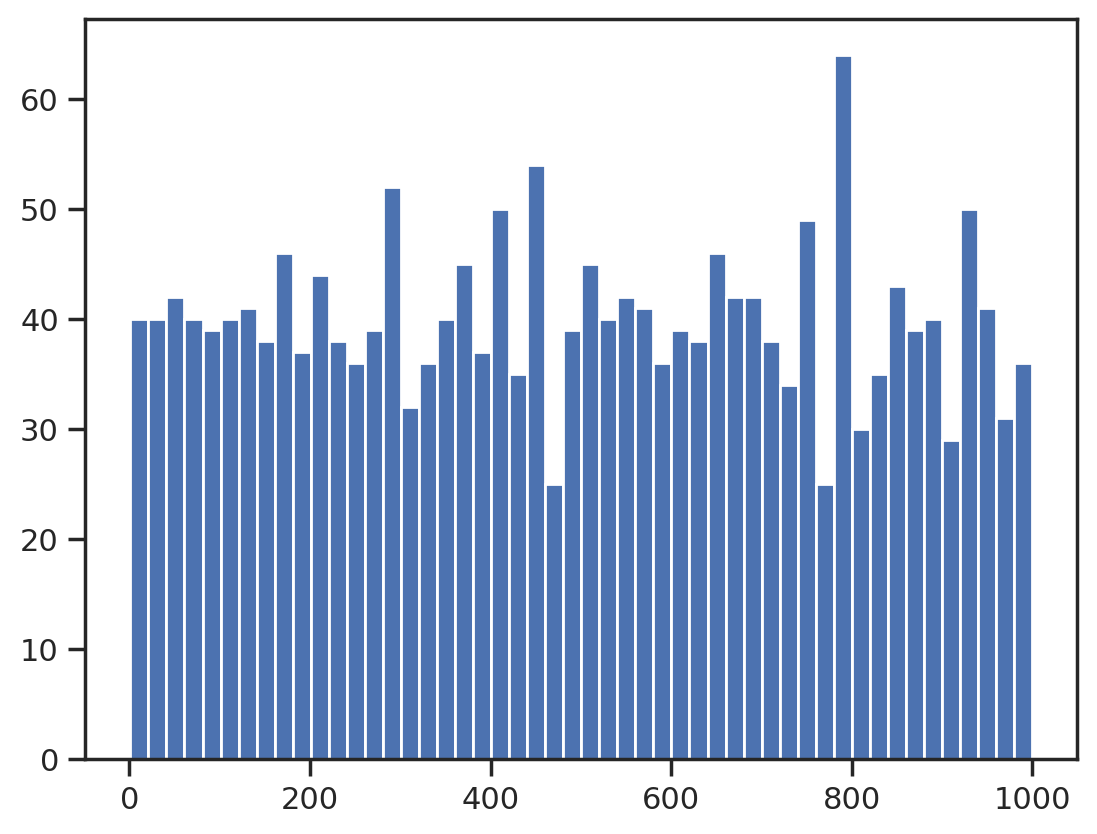

In [ ]:
plt.hist(data_digit['broad_impact'], 50)
plt.show()

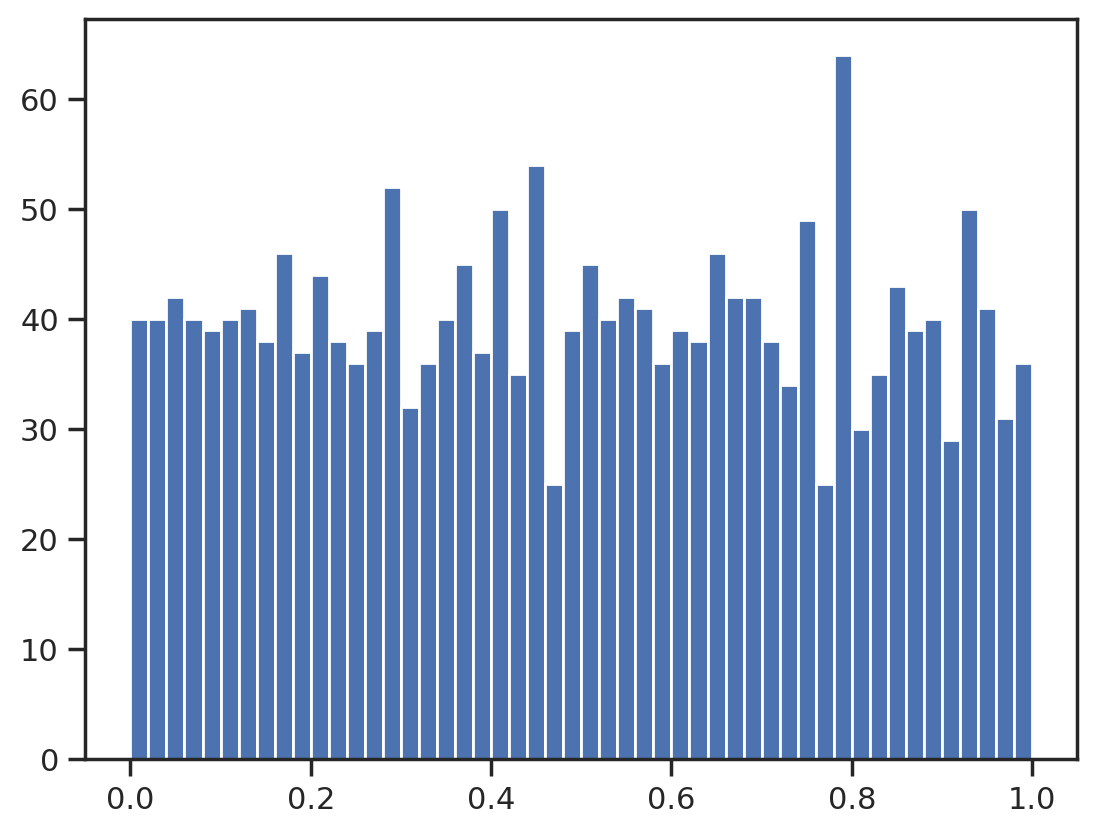

In [ ]:
plt.hist(sc1_data, 50)
plt.show()

=====> institution <=====

In [ ]:
sc2 = MinMaxScaler()
sc2_data = sc2.fit_transform(data_digit[['institution']])

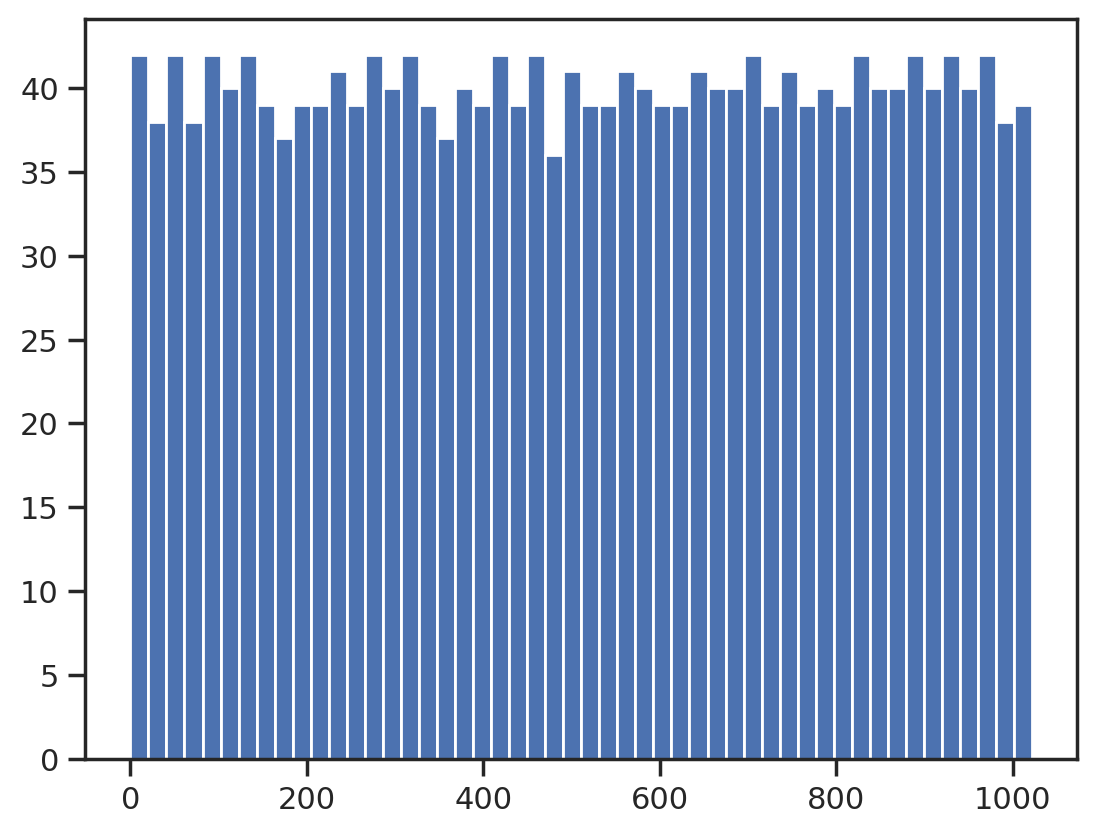

In [ ]:
plt.hist(data_digit['institution'], 50)
plt.show()

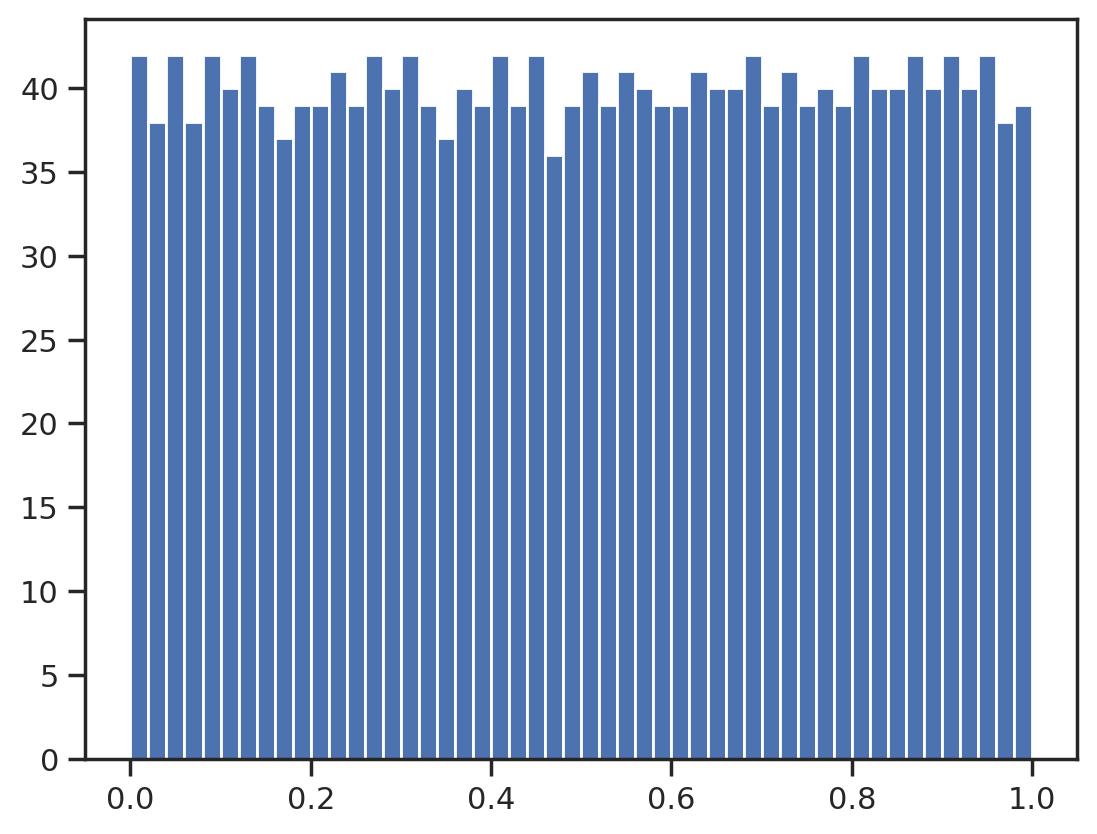

In [ ]:
plt.hist(sc2_data, 50)
plt.show()

=====> country <=====

In [ ]:
sc3 = MinMaxScaler()
sc3_data = sc3.fit_transform(data_digit[['country']])

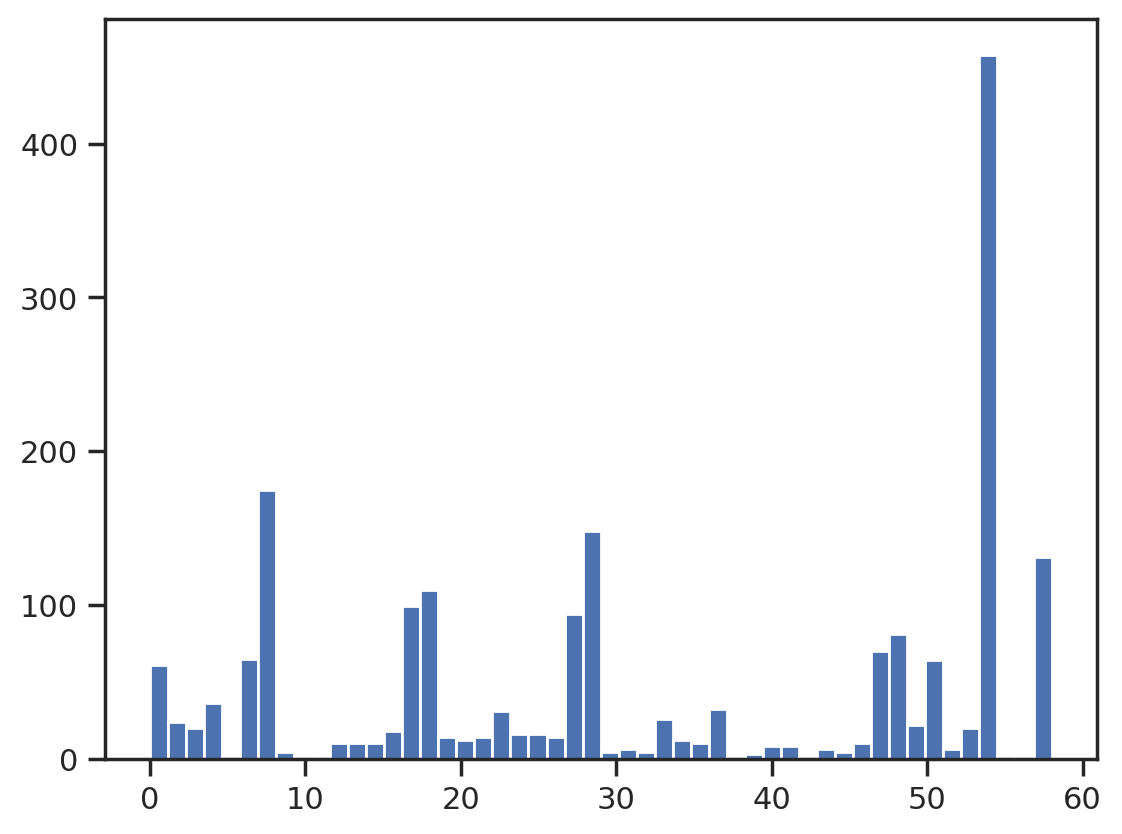

In [ ]:
plt.hist(data_digit['country'], 50)
plt.show()

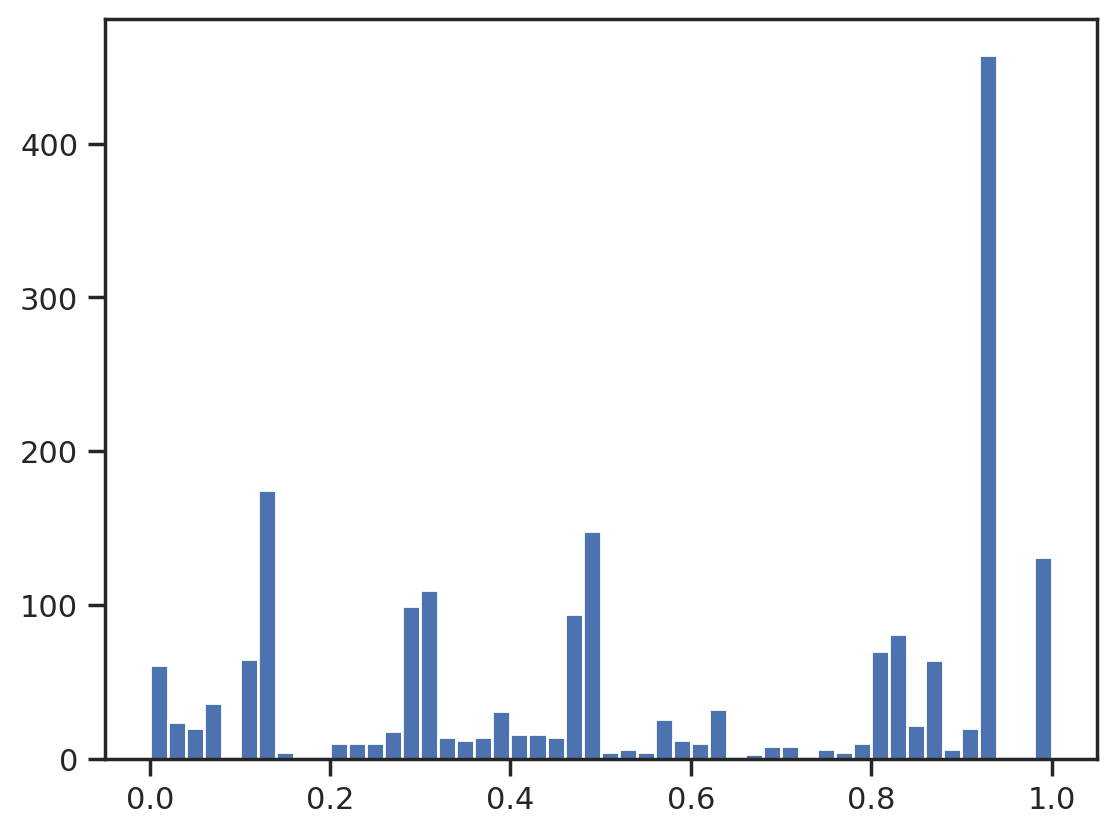

In [ ]:
plt.hist(sc3_data, 50)
plt.show()

=====> national_rank <=====

In [ ]:
sc4 = MinMaxScaler()
sc4_data = sc4.fit_transform(data_digit[['national_rank']])

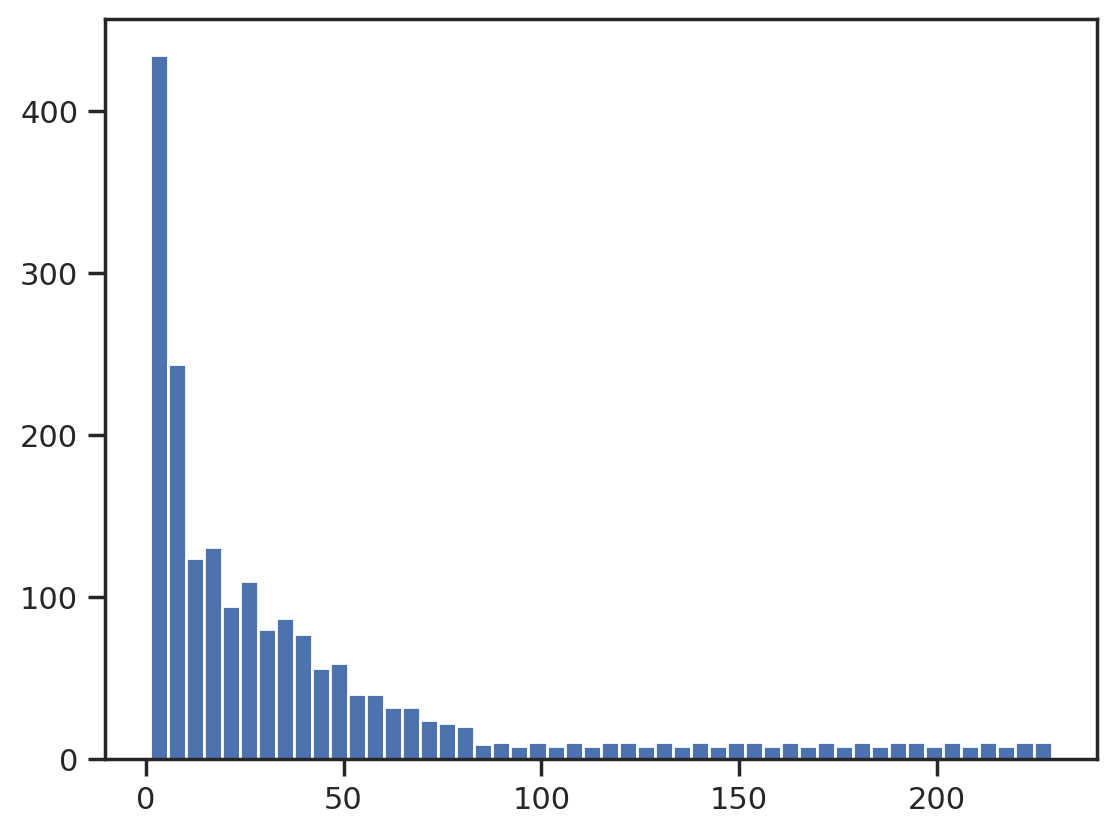

In [ ]:
plt.hist(data_digit['national_rank'], 50)
plt.show()

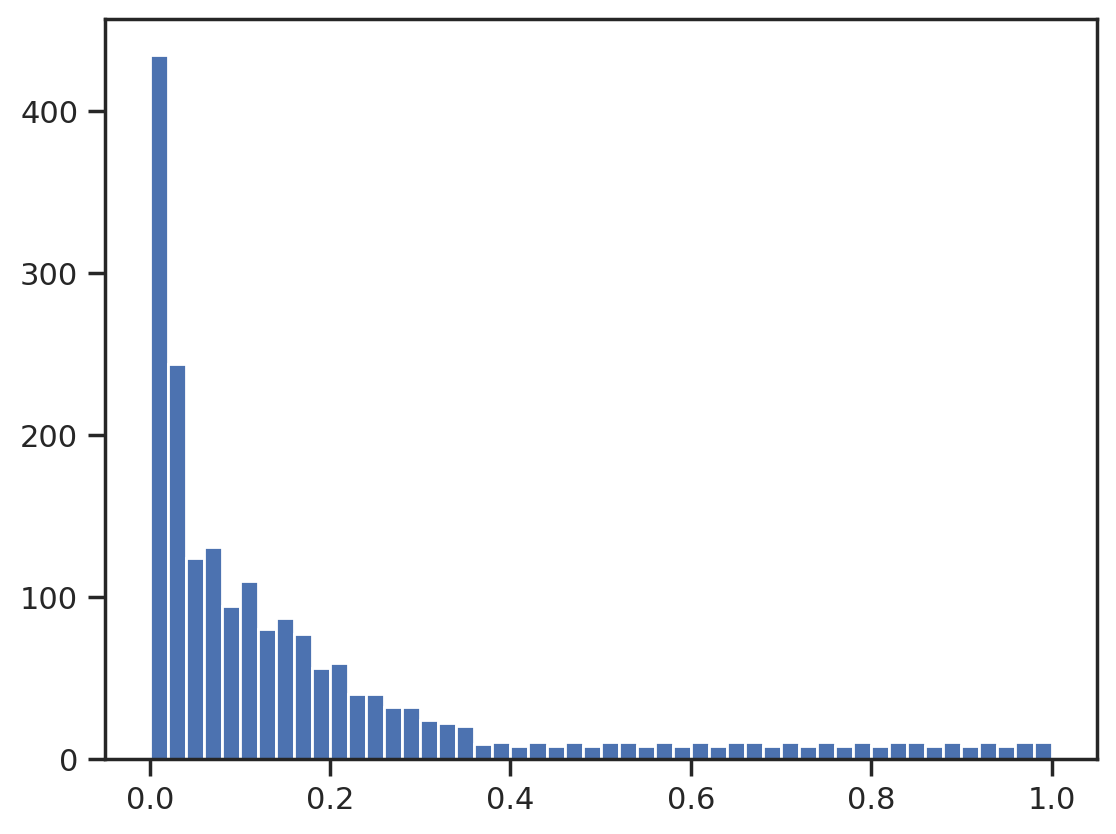

In [ ]:
plt.hist(sc4_data, 50)
plt.show()

=====> quality_of_education <=====

In [ ]:
sc5 = MinMaxScaler()
sc5_data = sc5.fit_transform(data_digit[['quality_of_education']])

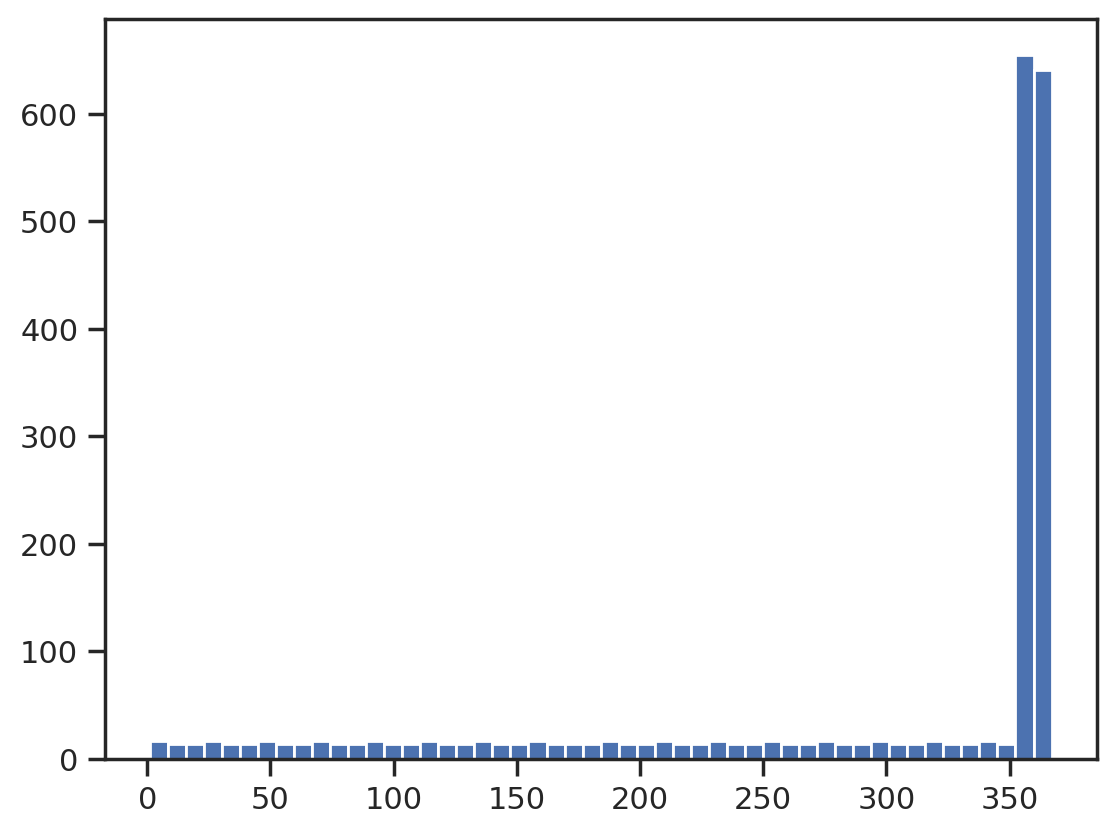

In [ ]:
plt.hist(data_digit['quality_of_education'], 50)
plt.show()

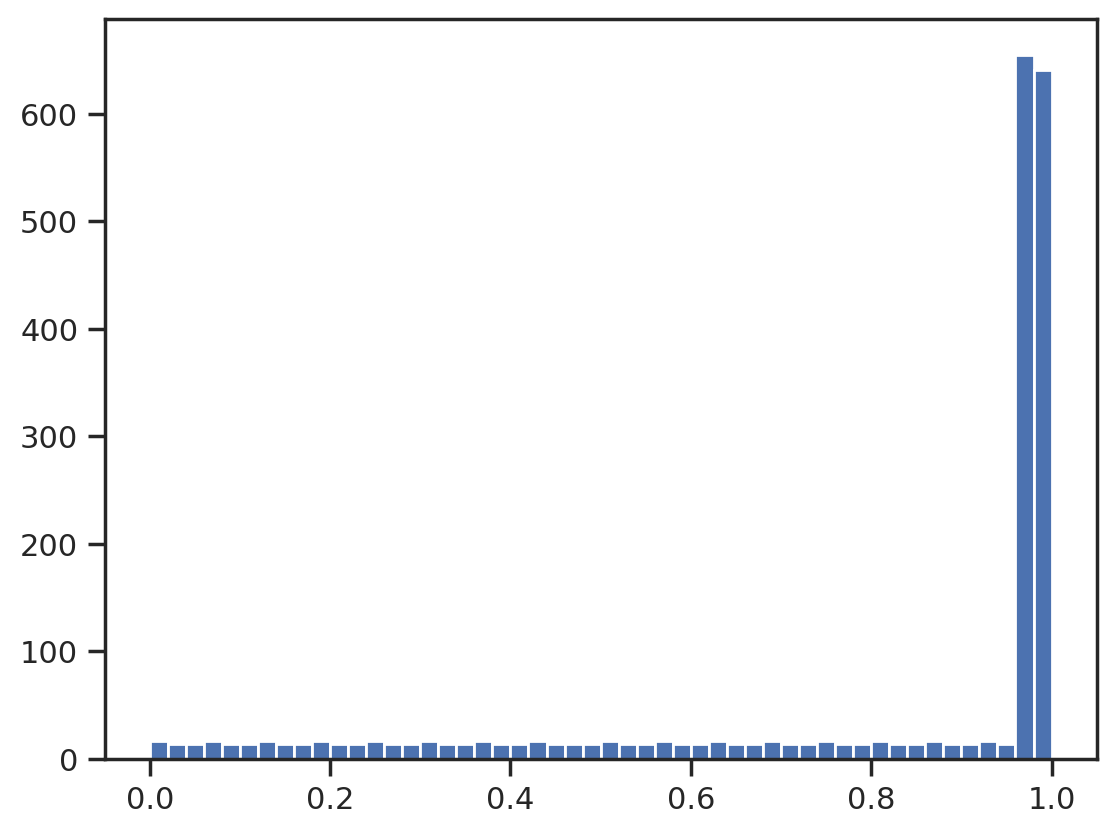

In [ ]:
plt.hist(sc5_data, 50)
plt.show()

=====> alumni_employment <=====

In [ ]:
sc6 = MinMaxScaler()
sc6_data = sc6.fit_transform(data_digit[['alumni_employment']])

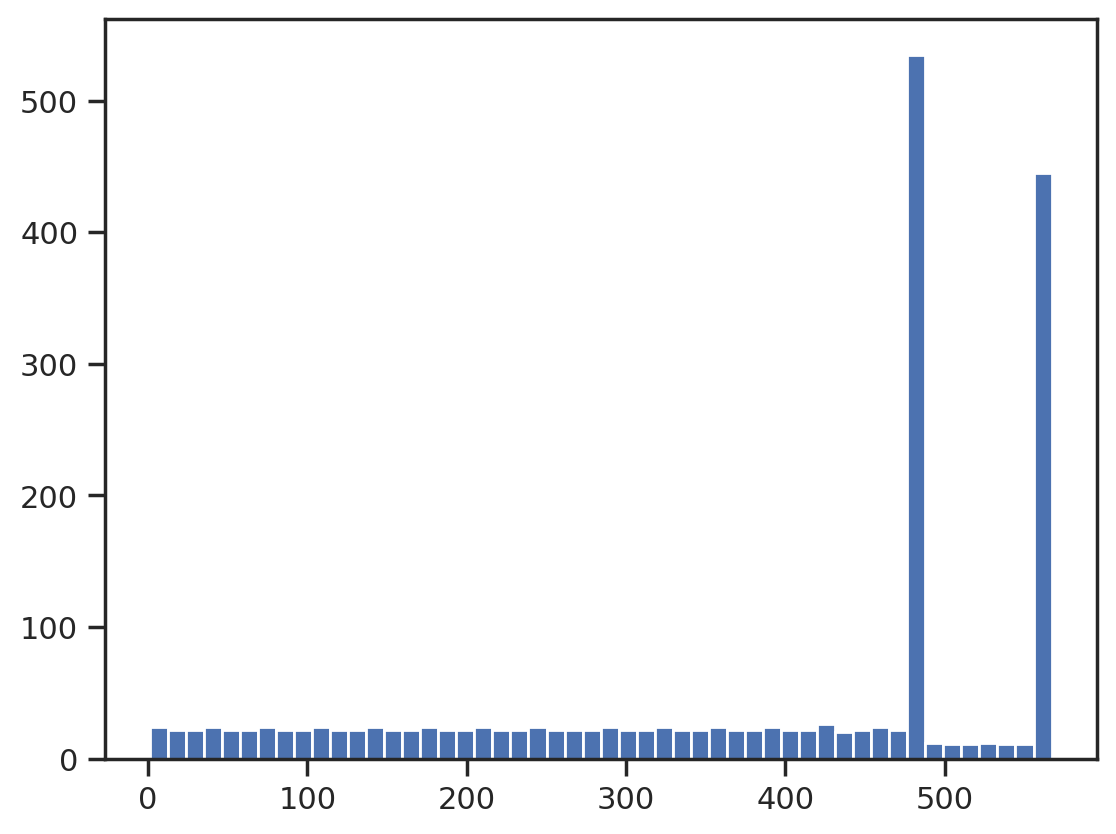

In [ ]:
plt.hist(data_digit['alumni_employment'], 50)
plt.show()

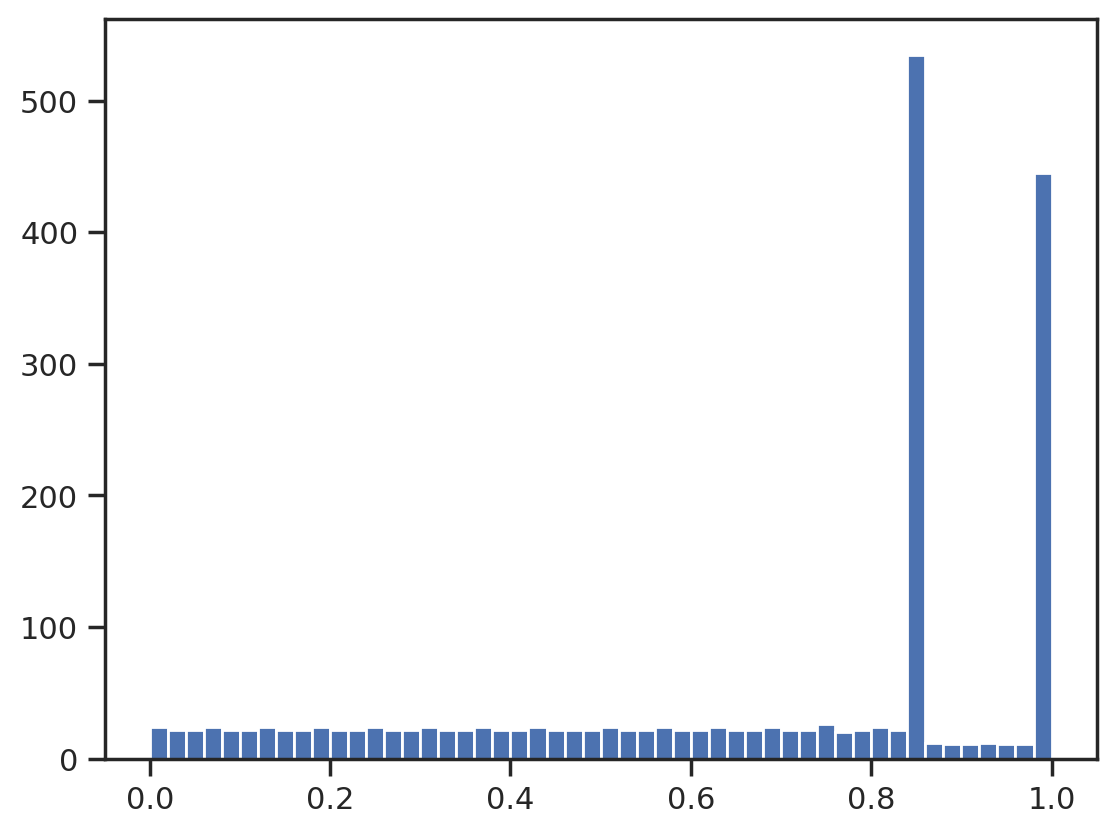

In [ ]:
plt.hist(sc6_data, 50)
plt.show()

=====> quality_of_faculty <=====

In [ ]:
sc7 = MinMaxScaler()
sc7_data = sc7.fit_transform(data_digit[['quality_of_faculty']])

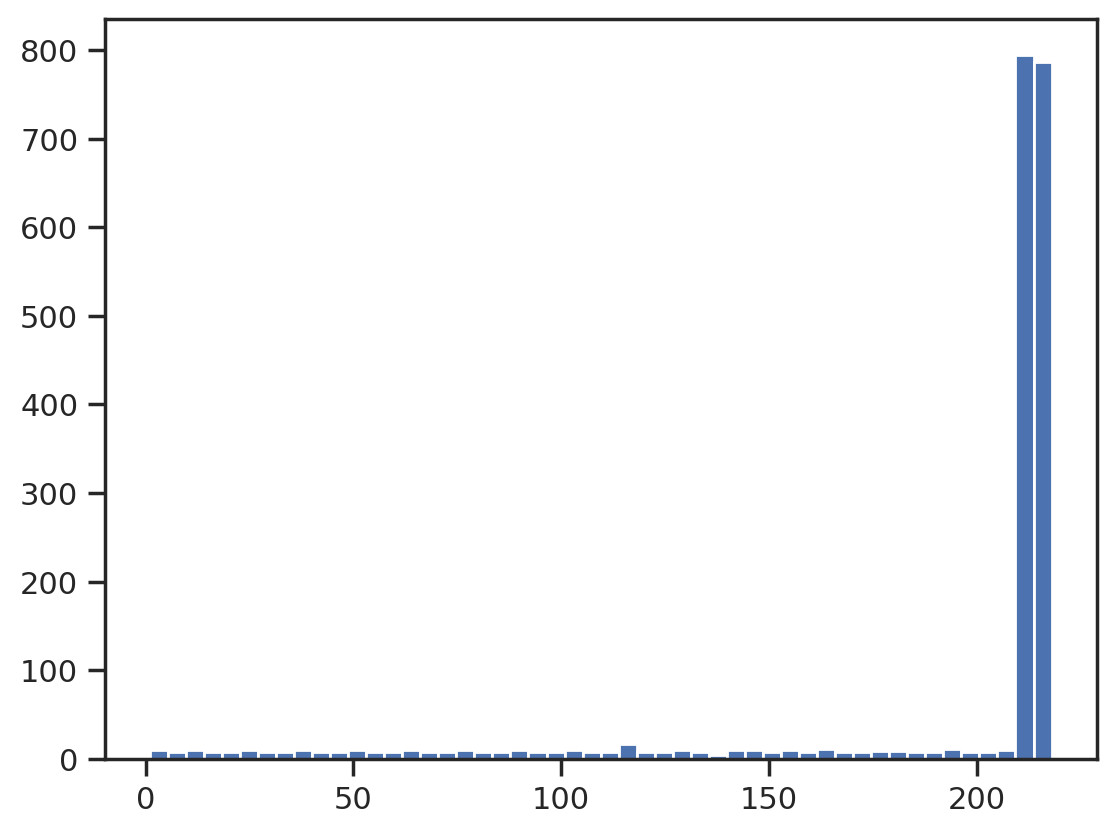

In [ ]:
plt.hist(data_digit['quality_of_faculty'], 50)
plt.show()

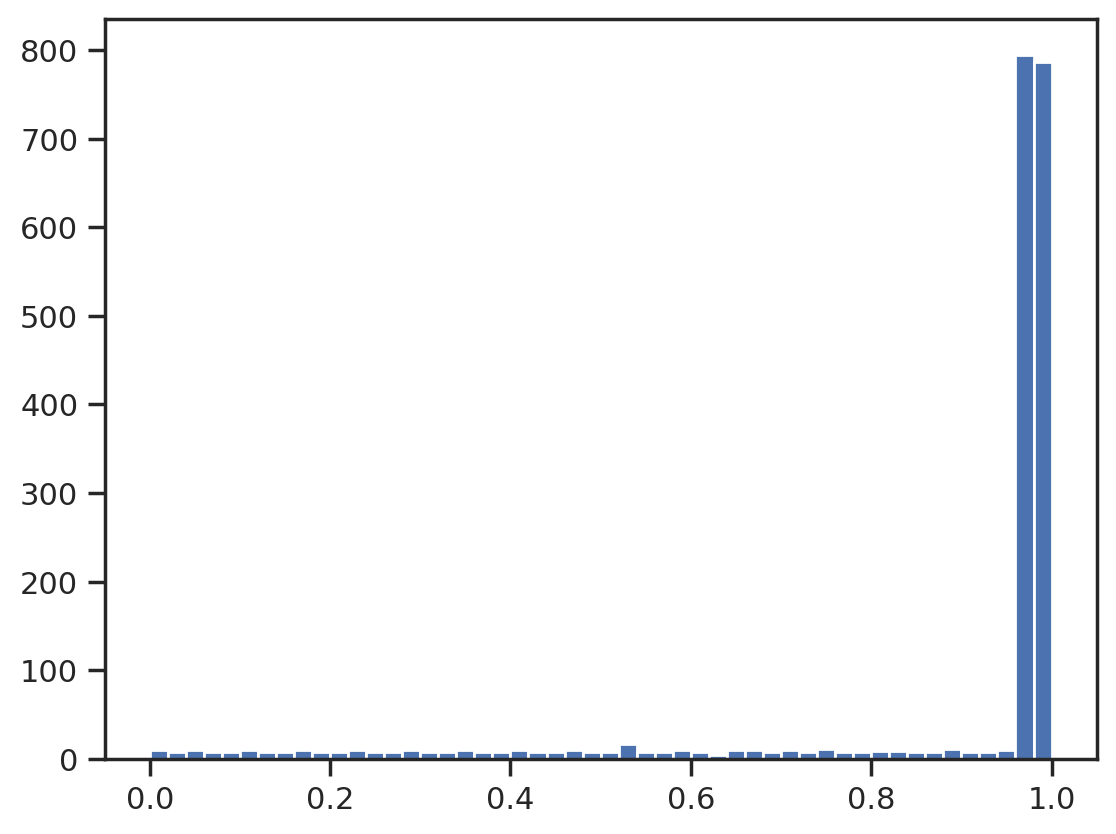

In [ ]:
plt.hist(sc7_data, 50)
plt.show()

=====> publications <=====

In [ ]:
sc8 = MinMaxScaler()
sc8_data = sc8.fit_transform(data_digit[['publications']])

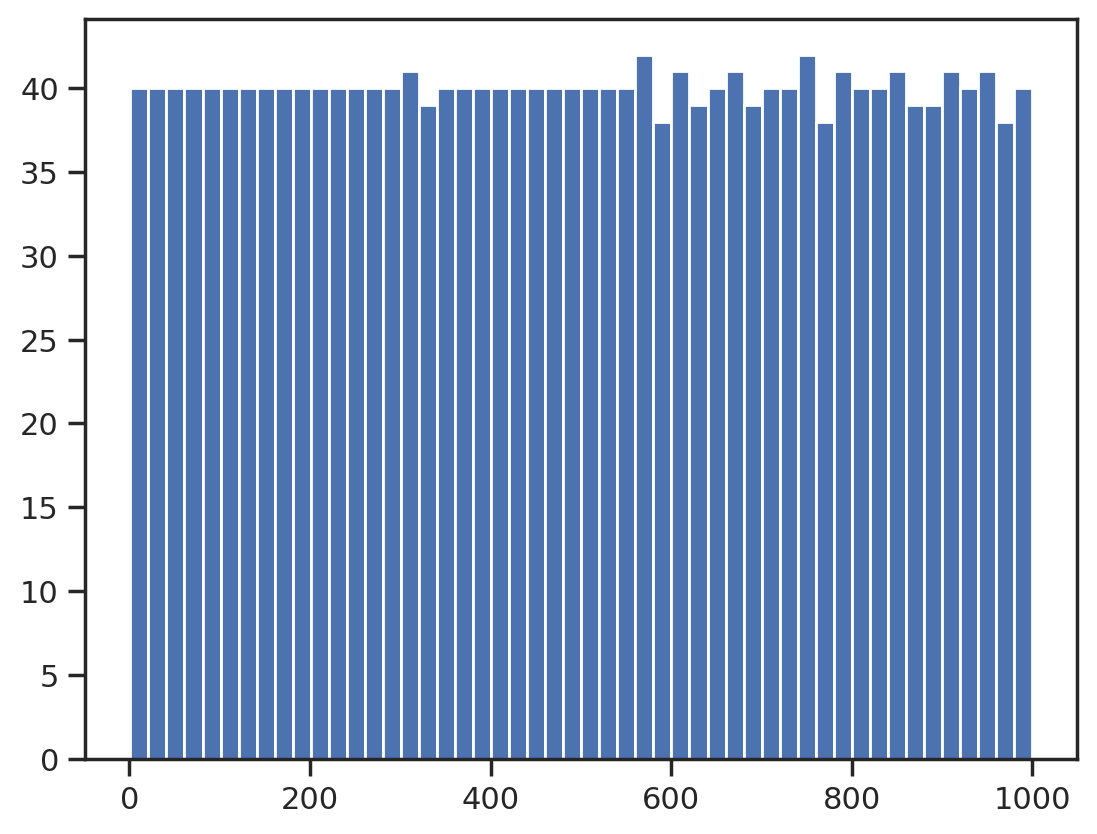

In [ ]:
plt.hist(data_digit['publications'], 50)
plt.show()

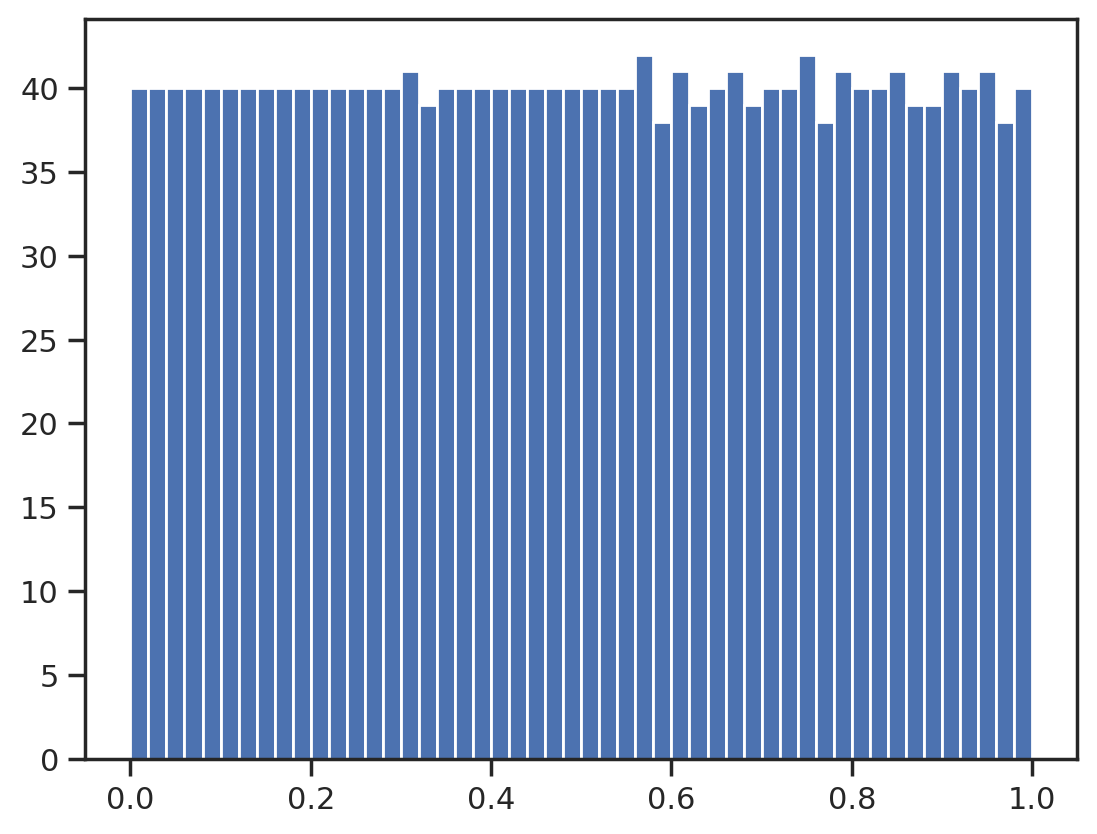

In [ ]:
plt.hist(sc8_data, 50)
plt.show()

=====> influence <=====

In [ ]:
sc9 = MinMaxScaler()
sc9_data = sc9.fit_transform(data_digit[['influence']])

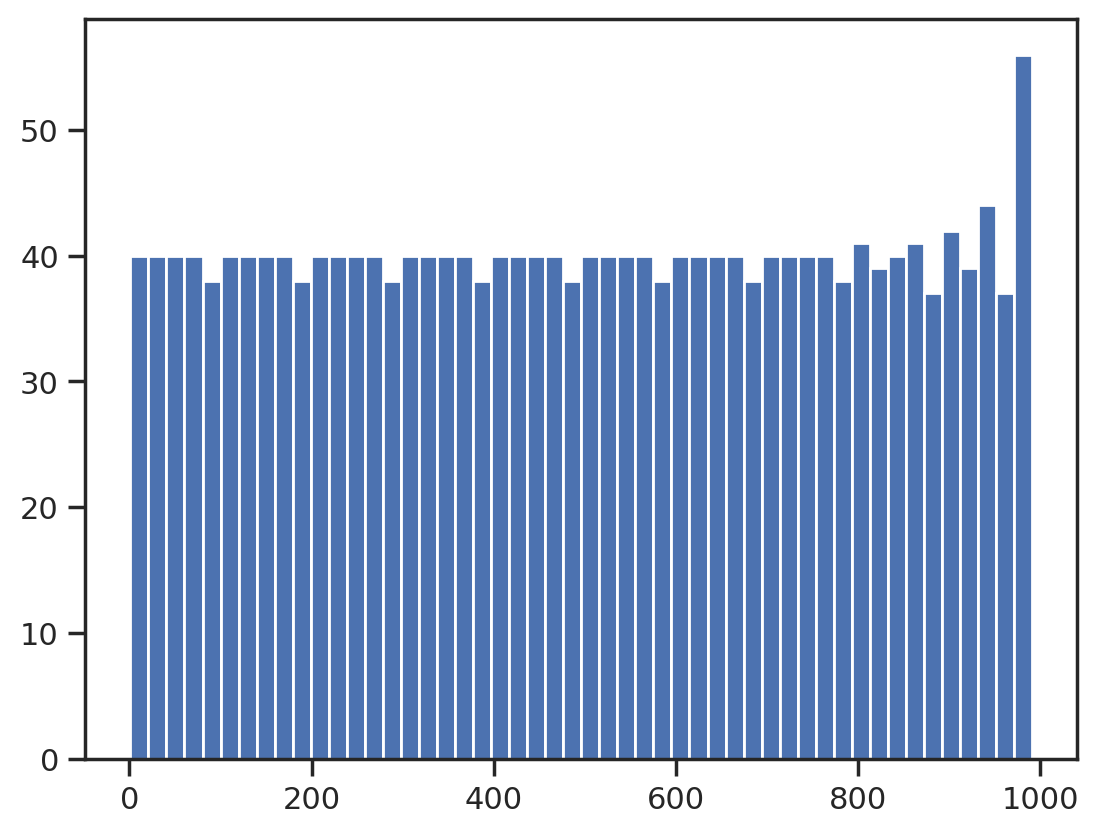

In [ ]:
plt.hist(data_digit['influence'], 50)
plt.show()

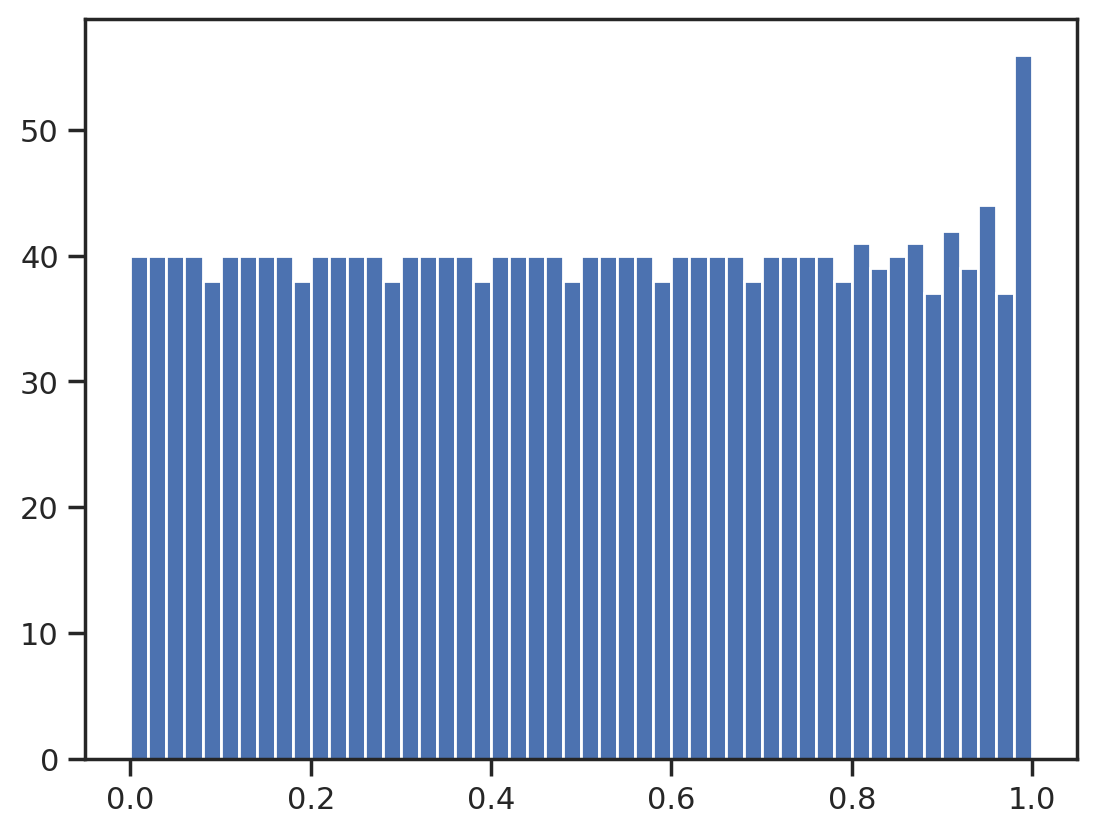

In [ ]:
plt.hist(sc9_data, 50)
plt.show()

=====> citations <=====

In [ ]:
sc10 = MinMaxScaler()
sc10_data = sc10.fit_transform(data_digit[['citations']])

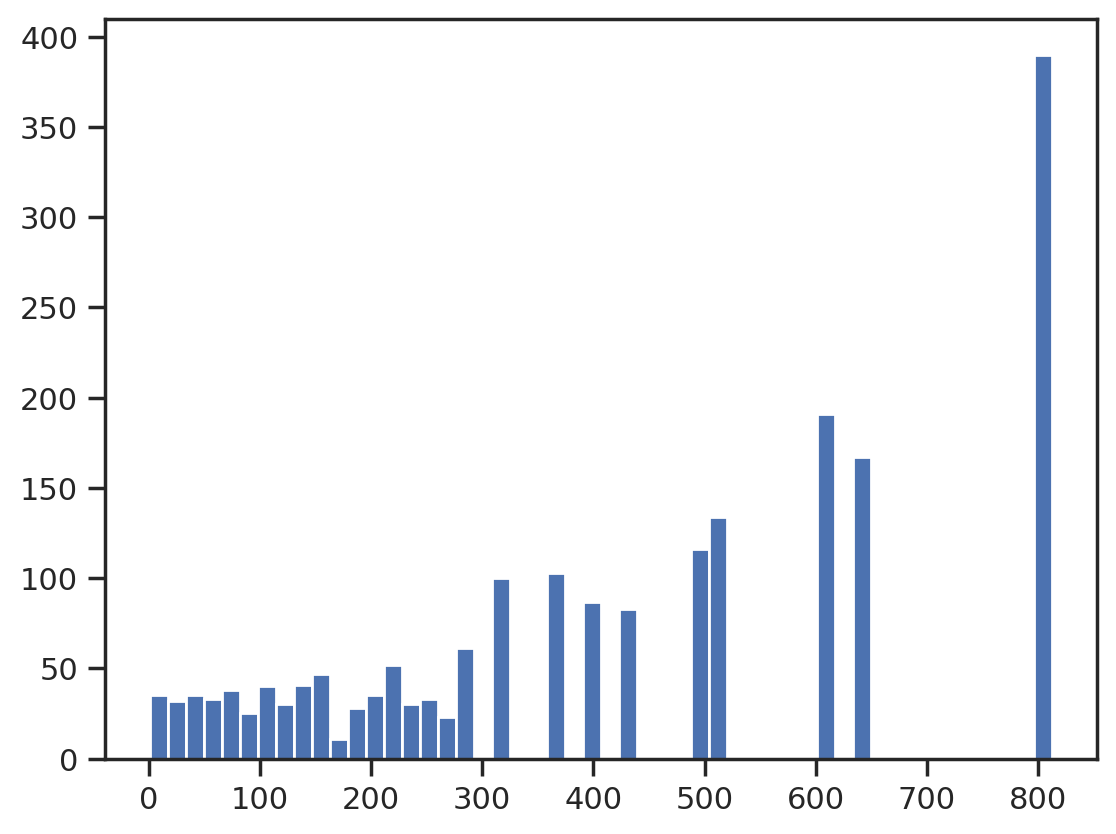

In [ ]:
plt.hist(data_digit['citations'], 50)
plt.show()

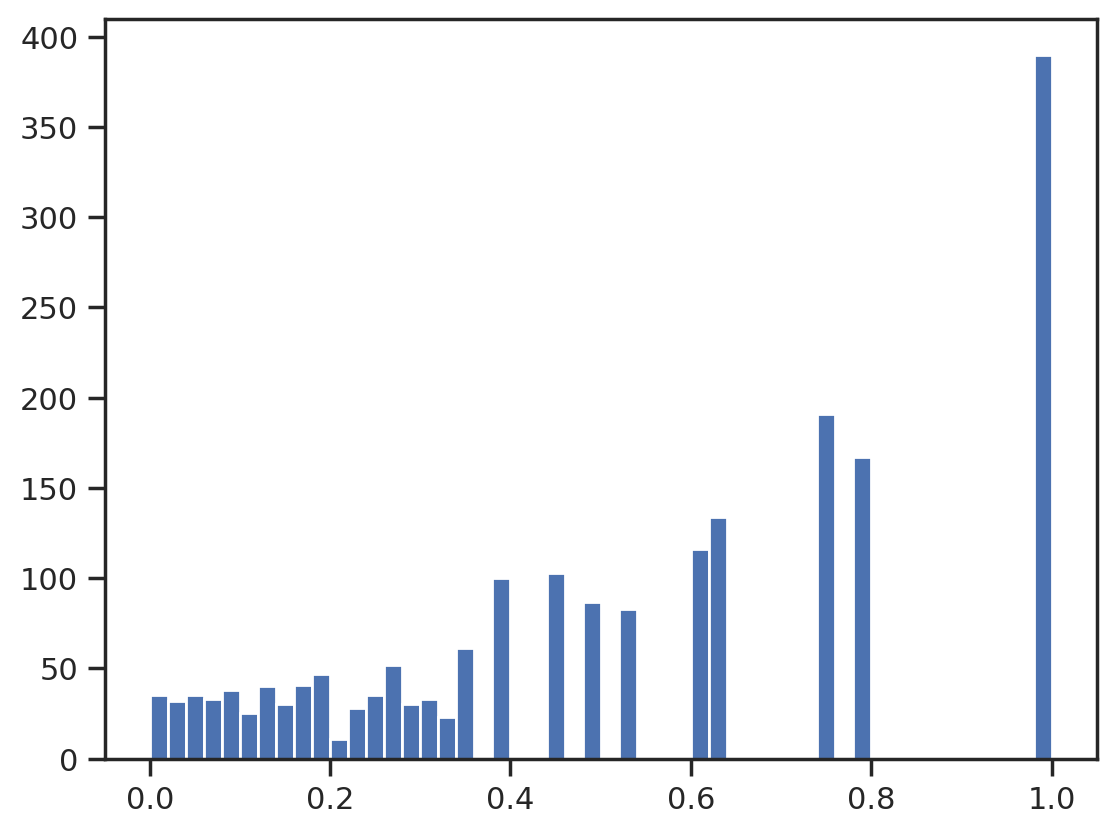

In [ ]:
plt.hist(sc10_data, 50)
plt.show()

=====> broad_impact <=====

In [ ]:
sc11 = MinMaxScaler()
sc11_data = sc11.fit_transform(data_digit[['broad_impact']])

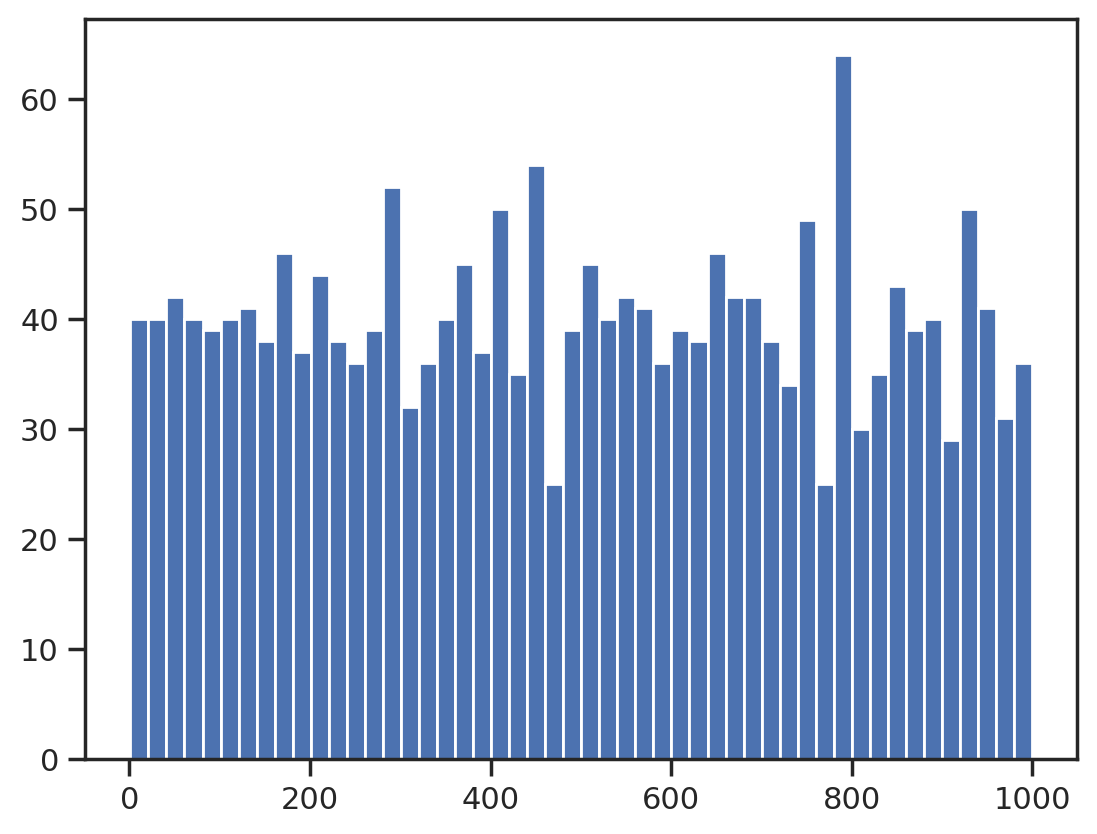

In [ ]:
plt.hist(data_digit['broad_impact'], 50)
plt.show()

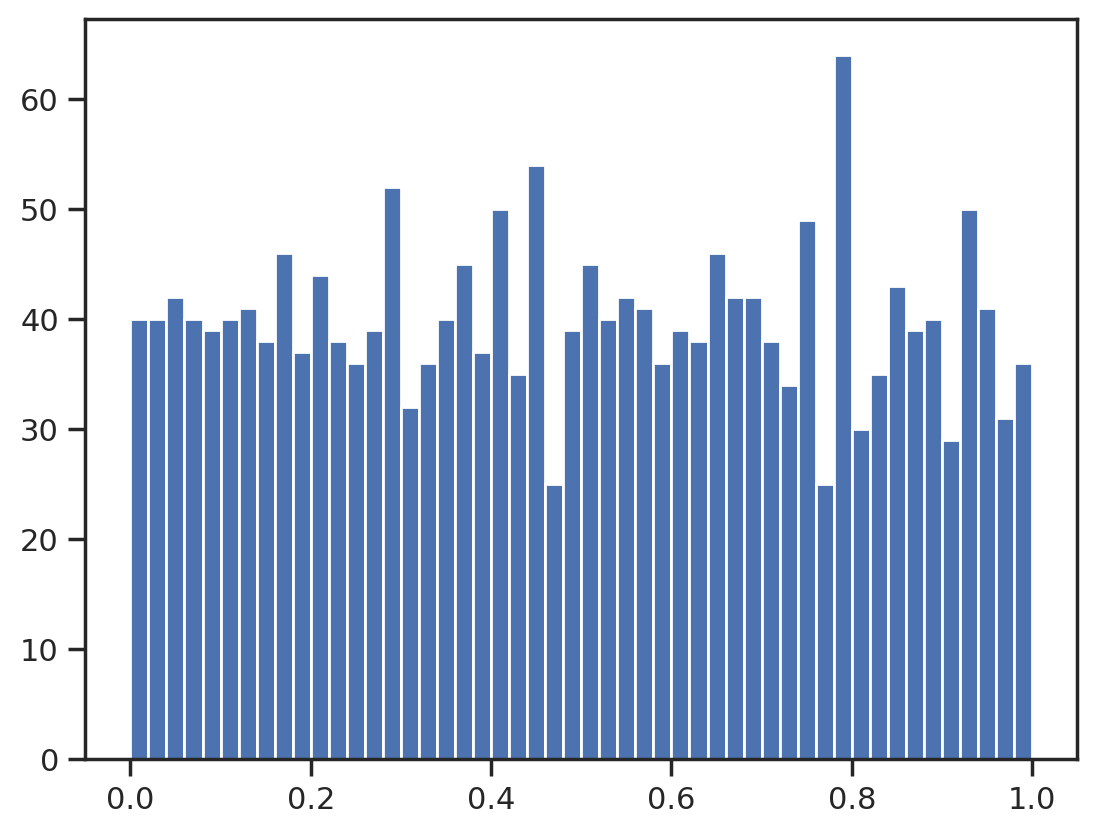

In [ ]:
plt.hist(sc11_data, 50)
plt.show()

=====> patents <=====

In [ ]:
sc12 = MinMaxScaler()
sc12_data = sc12.fit_transform(data_digit[['patents']])

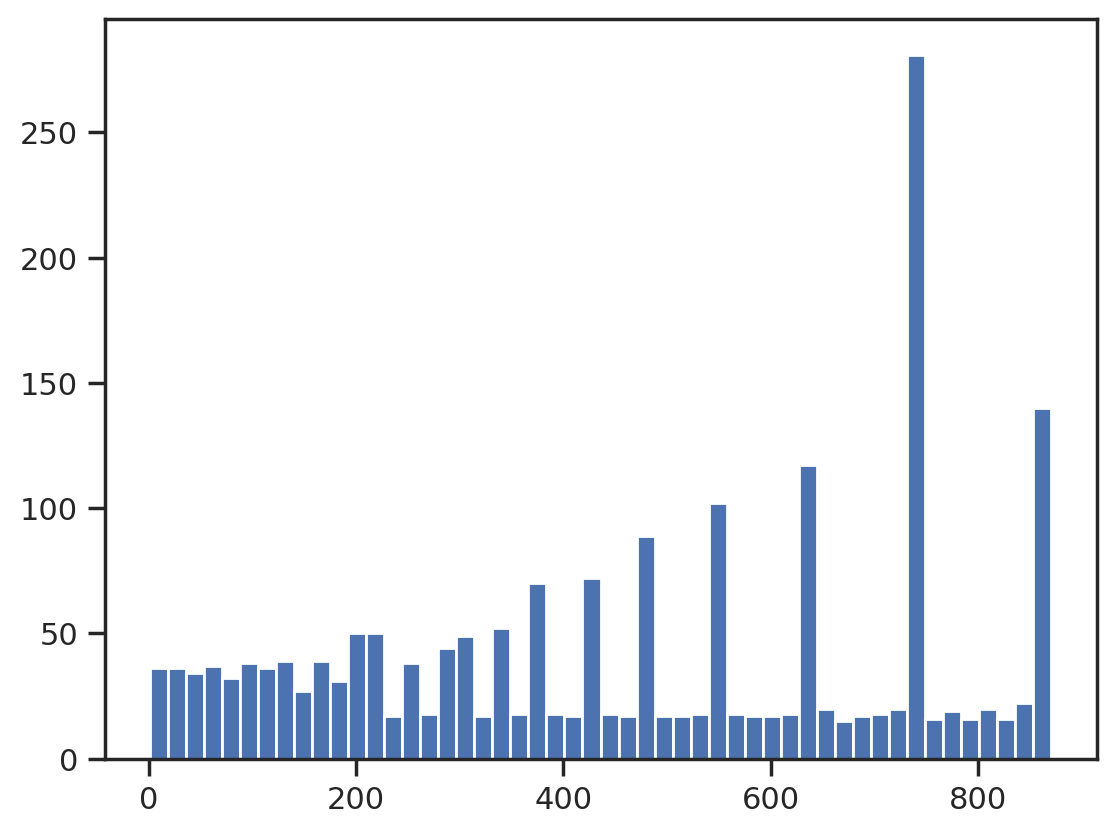

In [ ]:
plt.hist(data_digit['patents'], 50)
plt.show()

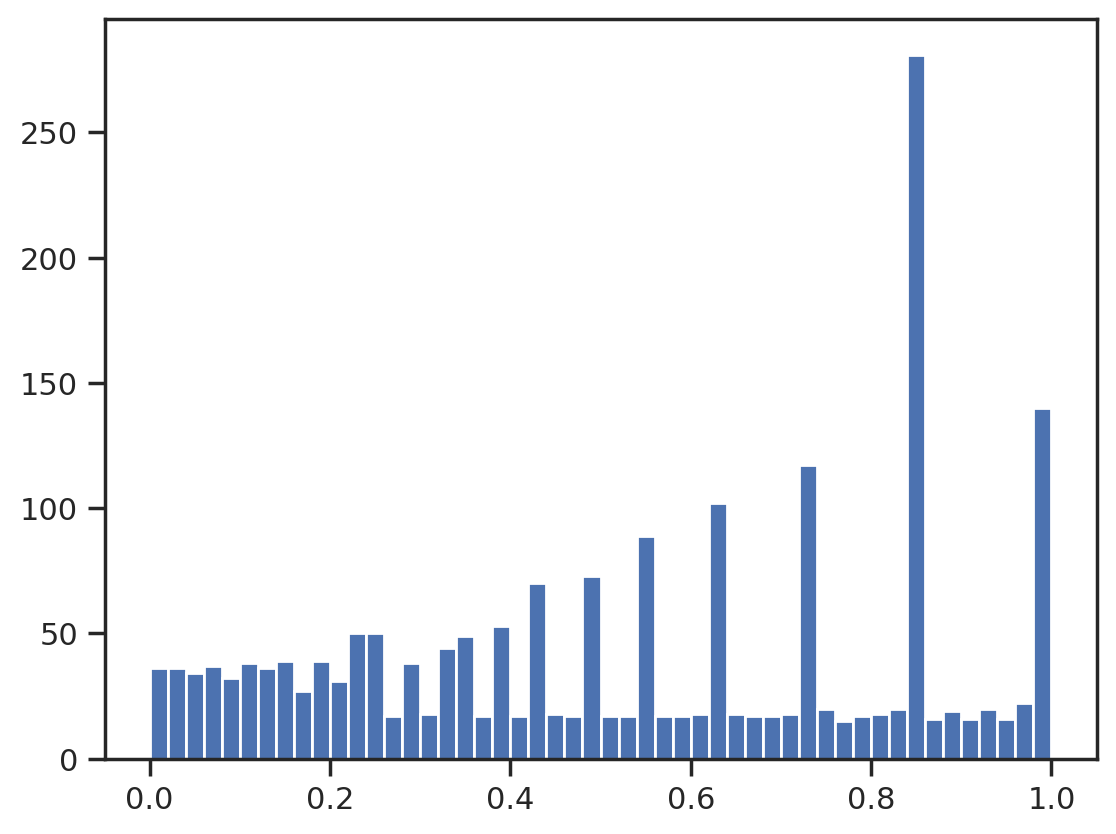

In [ ]:
plt.hist(sc12_data, 50)
plt.show()

=====> score <=====

In [ ]:
sc13 = MinMaxScaler()
sc13_data = sc13.fit_transform(data_digit[['score']])

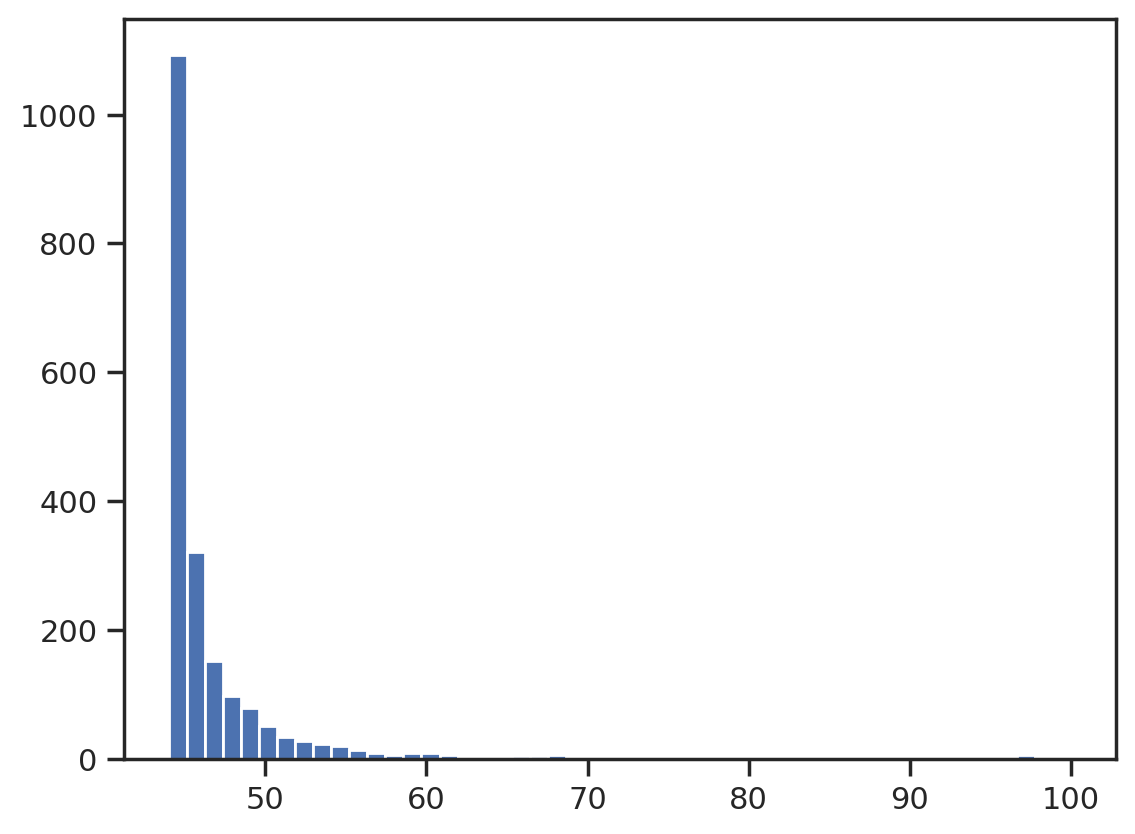

In [ ]:
plt.hist(data_digit['score'], 50)
plt.show()

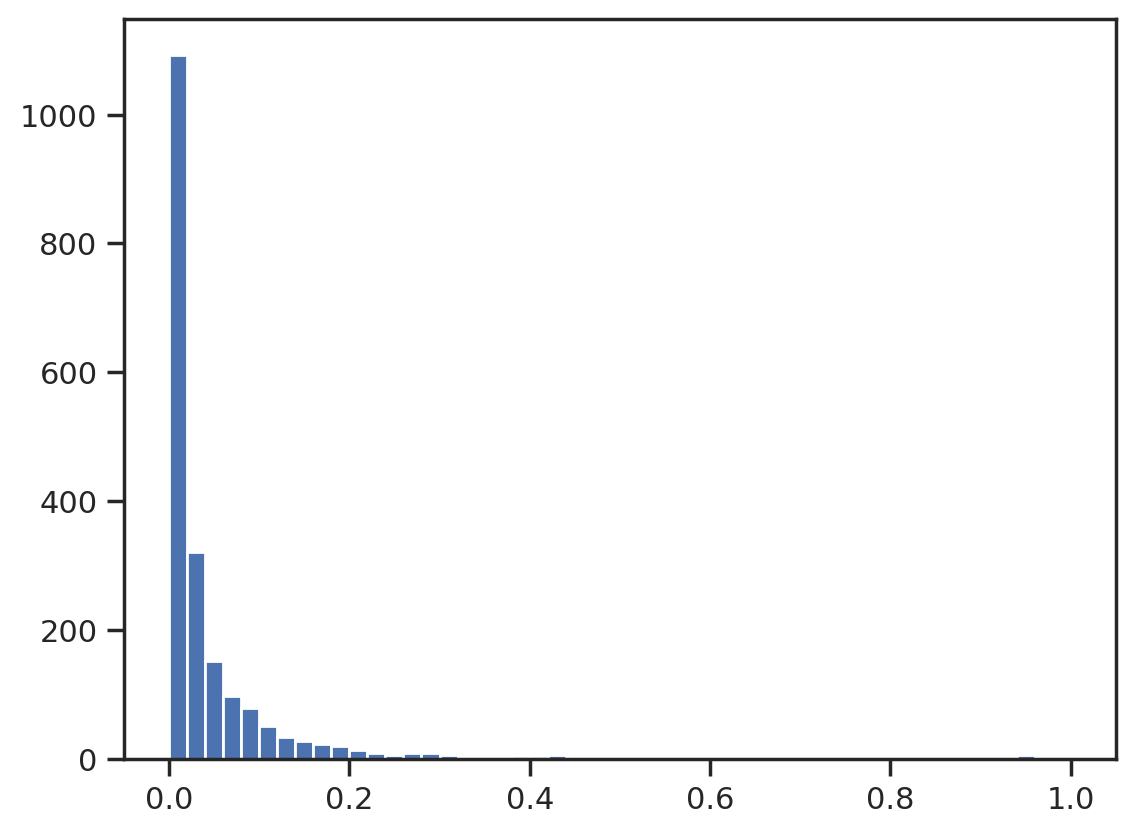

In [ ]:
plt.hist(sc13_data, 50)
plt.show()

=====> year <=====

In [ ]:
sc14 = MinMaxScaler()
sc14_data = sc14.fit_transform(data_digit[['year']])

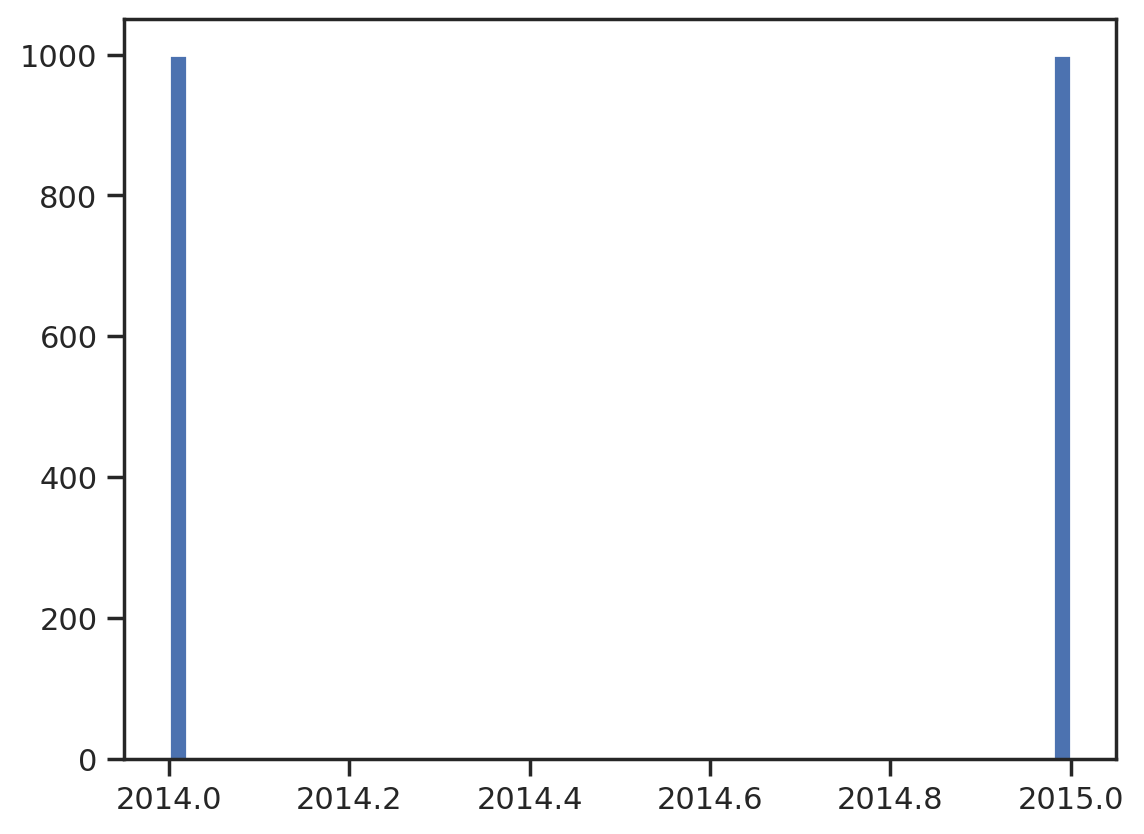

In [ ]:
plt.hist(data_digit['year'], 50)
plt.show()

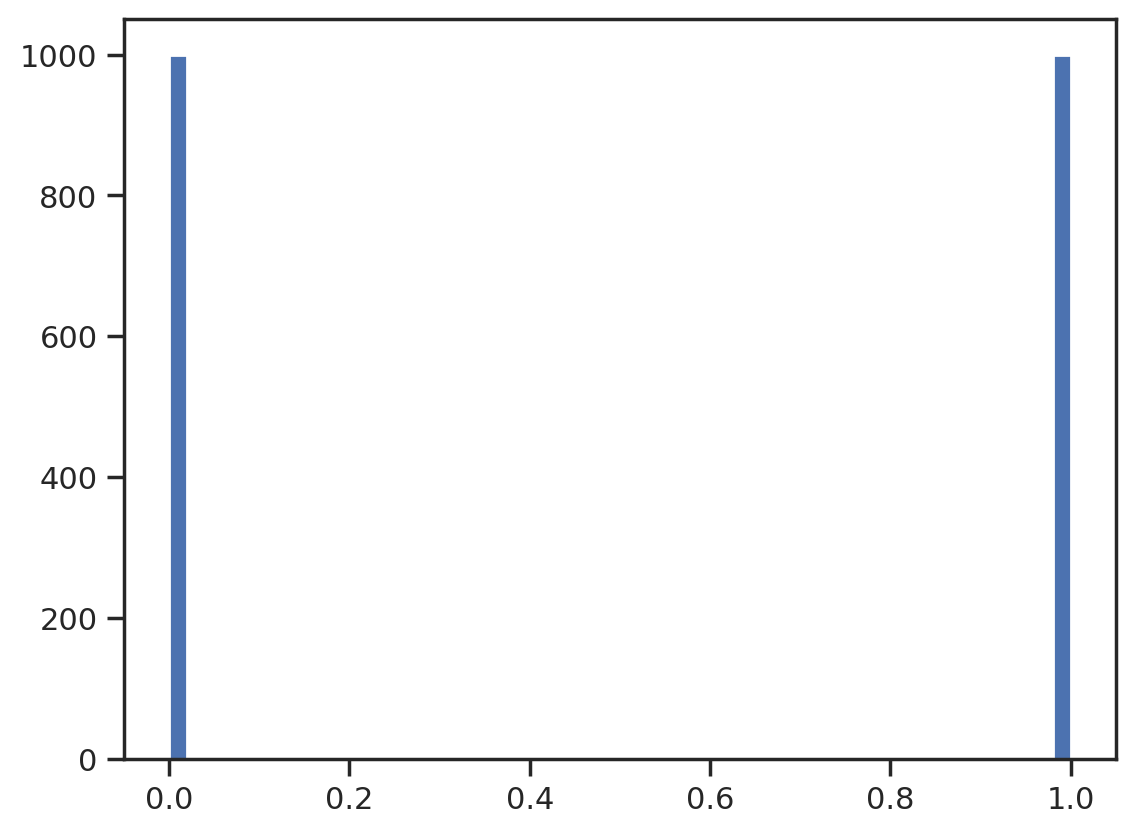

In [ ]:
plt.hist(sc14_data, 50)
plt.show()

### Сборка отмасштабированных данных в dataset

In [ ]:
data_normal = data_digit.copy()
data_normal['world_rank'] = sc1_data
data_normal['institution'] = sc2_data
data_normal['country'] = sc3_data
data_normal['national_rank'] = sc4_data
data_normal['quality_of_education'] = sc5_data
data_normal['alumni_employment'] = sc6_data
data_normal['quality_of_faculty'] = sc7_data
data_normal['publications'] = sc8_data
data_normal['influence'] = sc9_data
data_normal['citations'] = sc10_data
data_normal['broad_impact'] = sc11_data
data_normal['patents'] = sc12_data
data_normal['score'] = sc13_data
data_normal['year'] = sc14_data

In [ ]:
data_normal

,world_rank,institution,country,national_rank,quality_of_education,alumni_employment,quality_of_faculty,publications,influence,citations,broad_impact,patents,score,year
200,0.000000,0.180039,0.931034,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001149,1.000000,0.0
201,0.003003,0.500000,0.931034,0.004386,0.027322,0.001767,0.013825,0.004004,0.002020,0.002466,0.003003,0.005747,0.983744,0.0
202,0.001001,0.305284,0.931034,0.008772,0.005464,0.017668,0.004608,0.014014,0.001010,0.001233,0.001001,0.000000,0.976599,0.0
203,0.012012,0.623288,0.982759,0.000000,0.002732,0.015901,0.018433,0.009009,0.008081,0.013564,0.012012,0.054023,0.957842,0.0
204,0.011011,0.801370,0.982759,0.004386,0.016393,0.019435,0.041475,0.010010,0.011111,0.012330,0.011011,0.017241,0.955520,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2195,0.968969,0.933464,0.637931,0.026316,1.000000,1.000000,1.000000,0.925926,0.852525,1.000000,0.968969,0.936782,0.000179,1.0
2196,0.980981,0.010763,0.241379,0.013158,0.642077,0.998233,1.000000,0.996997,0.916162,0.794081,0.980981,1.000000,0.000179,1.0
2197,0.974975,0.129159,0.068966,0.074561,1.000000,0.968198,1.000000,0.829830,0.830303,1.000000,0.974975,0.945977,0.000179,1.0
2198,0.974975,0.563601,0.827586,0.171053,1.000000,1.000000,1.000000,0.885886,0.982828,1.000000,0.974975,0.747126,0.000000,1.0


Проверим кореляцию данных

<Axes: >

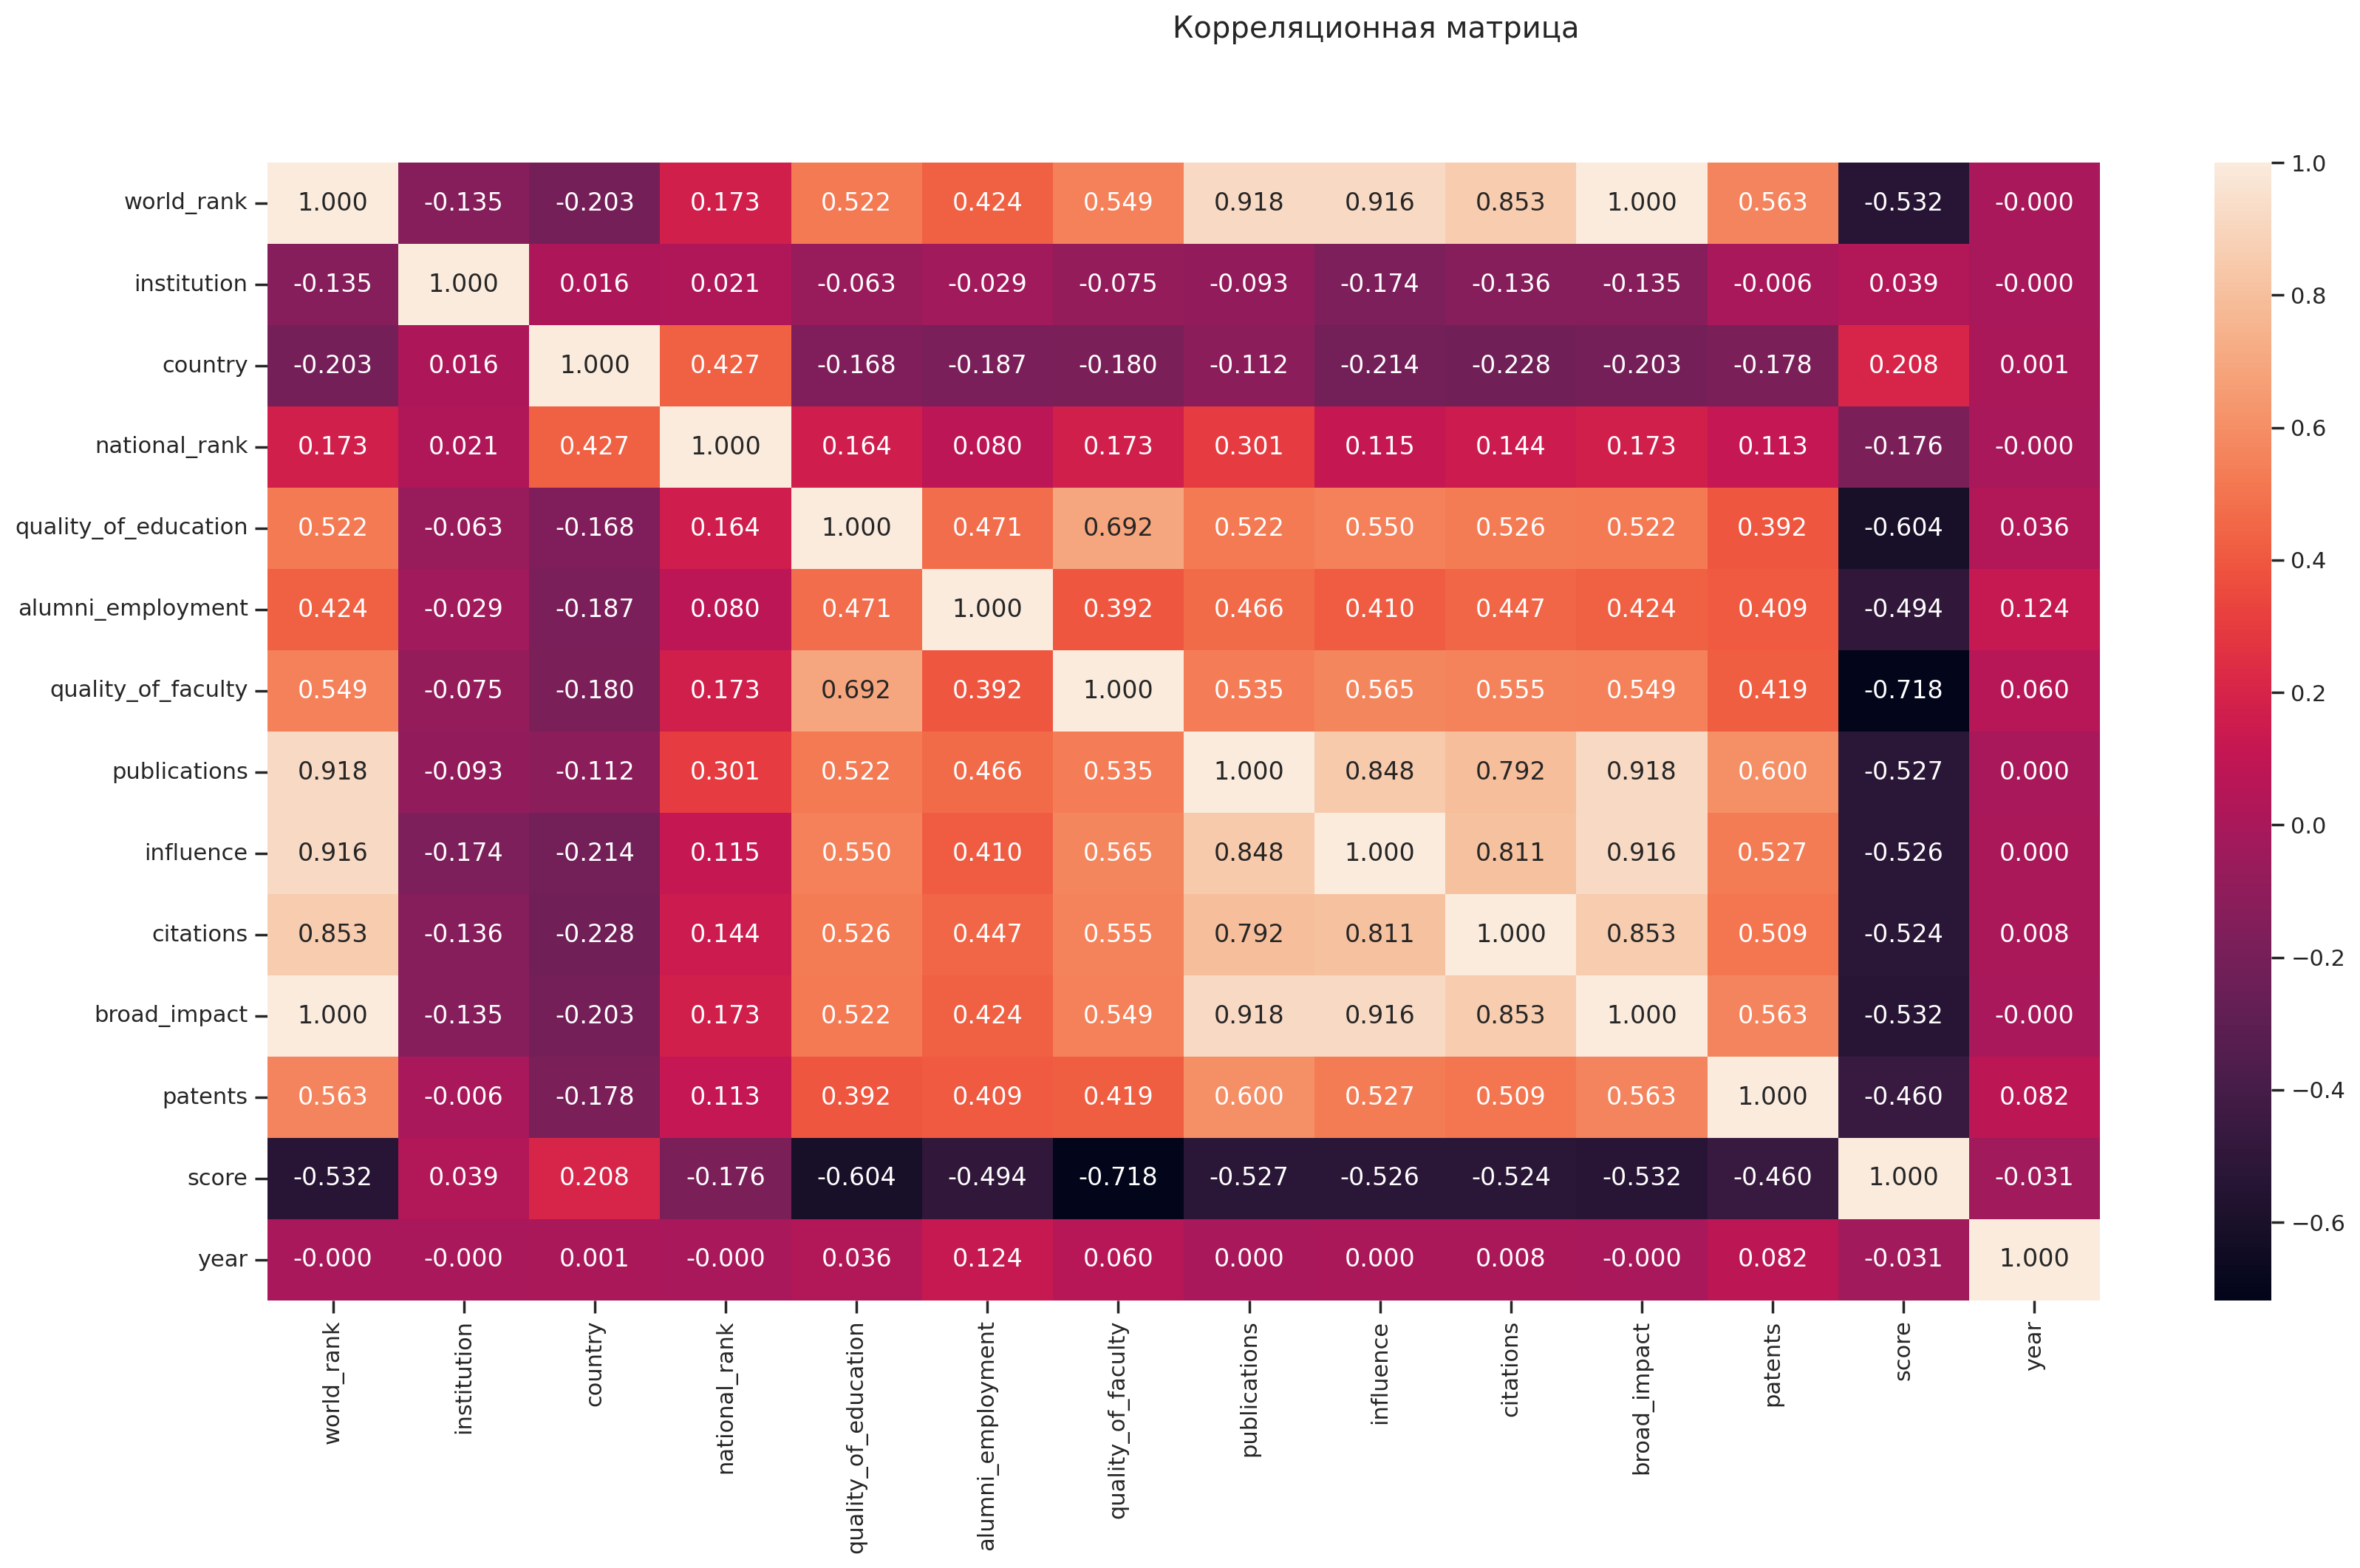

In [ ]:
fig, ax = plt.subplots(1, 1, sharex='col', sharey='row', figsize=(20,10))
fig.suptitle('Корреляционная матрица')
sns.heatmap(data_normal.corr(), ax=ax, annot=True, fmt='.3f')

Из кореляционной матрицы видно, что для определения целевого признака (world_rank) нужно знать только рейтинг за широкое влияние (broad_impact), поскольку коефициенк кореляции = 1,000

Год (year) вобще не корелирует с целевым признаком (коефициент = 0,000). Поэтому его можно исключить из модели

In [ ]:
data_normal = data_normal.drop(columns='year')
data_normal = data_normal.drop(columns='national_rank')
data_normal = data_normal.drop(columns='score')

<Axes: >

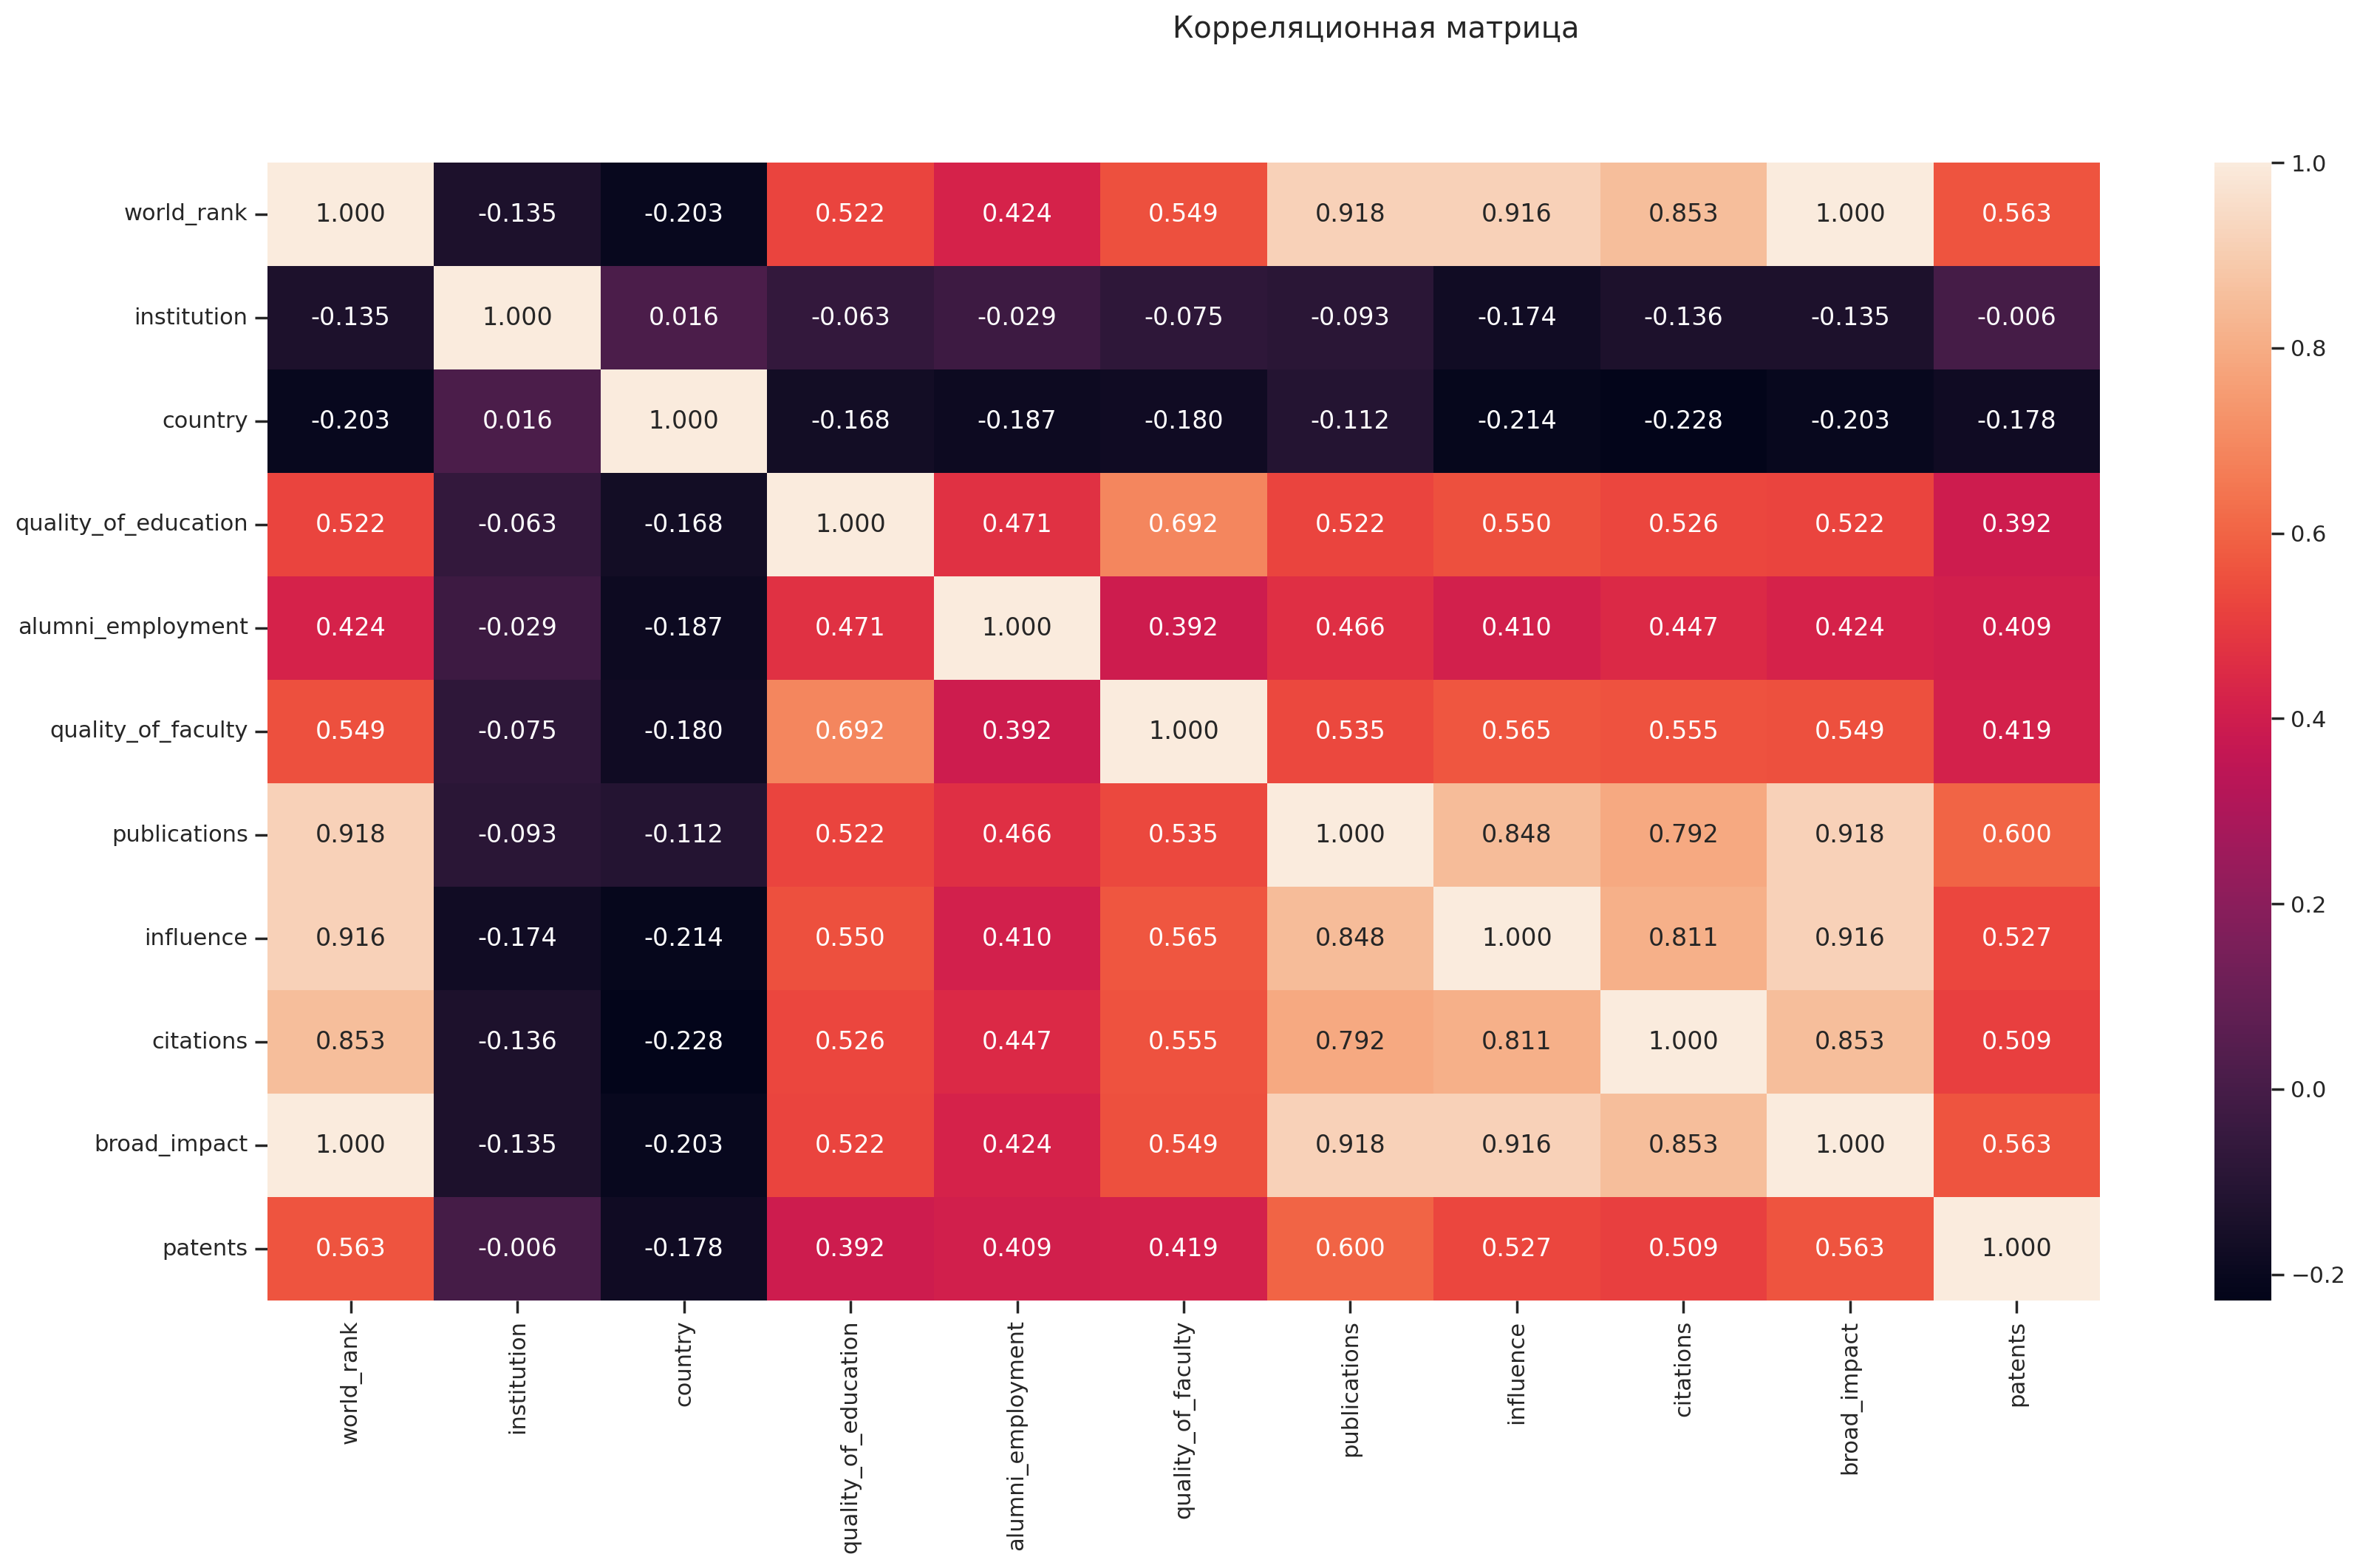

In [ ]:
fig, ax = plt.subplots(1, 1, sharex='col', sharey='row', figsize=(20,10))
fig.suptitle('Корреляционная матрица')
sns.heatmap(data_normal.corr(), ax=ax, annot=True, fmt='.3f')

### Разделение выборки на обучающую и тестовую


In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score, LeaveOneOut, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.metrics import accuracy_score, explained_variance_score, mean_absolute_error, max_error

В исходном наборе данных целевой признак не отделён от остальных данных, поэтому выделим набор данных, не содержащий world_rank

In [ ]:
data_x = data_normal.copy()
data_x = data_x.drop(columns='world_rank')
data_x

,institution,country,quality_of_education,alumni_employment,quality_of_faculty,publications,influence,citations,broad_impact,patents
200,0.180039,0.931034,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001149
201,0.500000,0.931034,0.027322,0.001767,0.013825,0.004004,0.002020,0.002466,0.003003,0.005747
202,0.305284,0.931034,0.005464,0.017668,0.004608,0.014014,0.001010,0.001233,0.001001,0.000000
203,0.623288,0.982759,0.002732,0.015901,0.018433,0.009009,0.008081,0.013564,0.012012,0.054023
204,0.801370,0.982759,0.016393,0.019435,0.041475,0.010010,0.011111,0.012330,0.011011,0.017241
...,...,...,...,...,...,...,...,...,...,...
2195,0.933464,0.637931,1.000000,1.000000,1.000000,0.925926,0.852525,1.000000,0.968969,0.936782
2196,0.010763,0.241379,0.642077,0.998233,1.000000,0.996997,0.916162,0.794081,0.980981,1.000000
2197,0.129159,0.068966,1.000000,0.968198,1.000000,0.829830,0.830303,1.000000,0.974975,0.945977
2198,0.563601,0.827586,1.000000,1.000000,1.000000,0.885886,0.982828,1.000000,0.974975,0.747126


In [ ]:
data_y = data_normal['world_rank']
data_y

200     0.000000
201     0.003003
202     0.001001
203     0.012012
204     0.011011
          ...   
2195    0.968969
2196    0.980981
2197    0.974975
2198    0.974975
2199    0.980981
Name: world_rank, Length: 2000, dtype: float64

Зададим тестовую выборку с размером 10%



In [ ]:
data_X_train, data_X_test, data_y_train, data_y_test = train_test_split(data_x, data_y, test_size=0.2, random_state=2022)

### Метод ближайших соседей
### Первичное обучение модели и оценка качества

In [ ]:
#cl1_1 = KNeighborsClassifier(n_neighbors=3) # Классификация в данной задаче не работает
cl1_1 = KNeighborsRegressor(n_neighbors=3)   # Используем регрессию
cl1_1.fit(data_X_train, data_y_train)
target1_0 = cl1_1.predict(data_X_train)
target1_1 = cl1_1.predict(data_X_test)
#accuracy_score(data_y_train, target1_0), accuracy_score(data_y_test, target1_1)
max_error(data_y_train, target1_0), max_error(data_y_test, target1_1)

(0.17584250917584254, 0.21688355021688355)

## Оценка качества модели с использованием кросс-валидации


In [ ]:
#scores = cross_val_score(KNeighborsRegressor(n_neighbors=3), data_x, data_y, cv=LeaveOneOut()) # bug https://github.com/scikit-learn/scikit-learn/issues/11435
scores = cross_val_score(KNeighborsRegressor(n_neighbors=3), data_x, data_y, cv=5)
scores, np.mean(scores)

(array([0.90762872, 0.78141885, 0.98239803, 0.8687708 , 0.79487252]),
 0.8670177827458012)

In [ ]:
n_range = np.array(range(5,55,5))
tuned_parameters = [{'n_neighbors': n_range}]
tuned_parameters

[{'n_neighbors': array([ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50])}]

Получим максимальную остаточную ошибку, используя всю выборку



In [ ]:
%%time
reg_gs = GridSearchCV(KNeighborsRegressor(), tuned_parameters, cv=3, scoring='max_error')
reg_gs.fit(data_x, data_y)

CPU times: user 781 ms, sys: 5.46 ms, total: 787 ms
Wall time: 781 ms


GridSearchCV(cv=3, estimator=KNeighborsRegressor(),
             param_grid=[{'n_neighbors': array([ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50])}],
             scoring='max_error')

In [ ]:
reg_gs.best_params_

{'n_neighbors': 5}

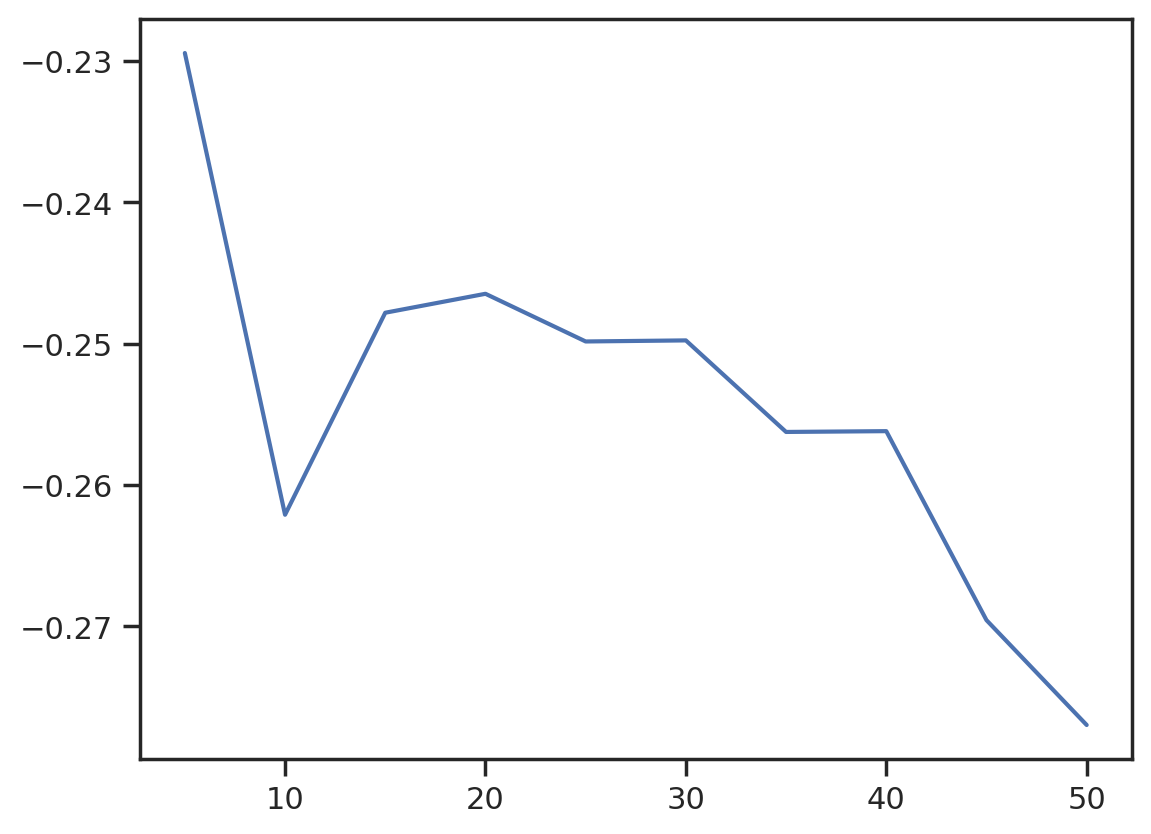

In [ ]:
plt.plot(n_range, reg_gs.cv_results_['mean_test_score'])

### Обучение модели и оценка качества с учетом подобранных гиперпараметров

In [ ]:
reg_gs.best_estimator_.fit(data_X_train, data_y_train)
target2_0 = reg_gs.best_estimator_.predict(data_X_train)
target2_1 = reg_gs.best_estimator_.predict(data_X_test)

Проверим новое качество модели



In [ ]:
max_error(data_y_train, target1_0), max_error(data_y_test, target1_1)

(0.17584250917584254, 0.21688355021688355)

Качество модели до подбора гиперпараметров

In [ ]:
max_error(data_y_train, target1_0), max_error(data_y_test, target1_1)

(0.17584250917584254, 0.21688355021688355)